In [224]:
import os
from sklearn.metrics import log_loss
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import random,math
seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
import eli5

In [225]:
%%time
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')

# train_pred = pd.read_csv('./simple_xgboost_cv.csv', index_col='TransactionID')
# test_pred = pd.read_csv('./simple_xgboost_pred.csv', index_col='TransactionID')
# test_pred['pred'] = (test_pred['pred1'] + test_pred['pred2'] + test_pred['pred3'] )/3
# del test_pred['pred1'],test_pred['pred2'],test_pred['pred3']

# train_f1 = pd.read_csv('../input/f1_train.csv', index_col='TransactionID')[["f148_amt_counts","f148_card1_counts"]]
# test_f1 = pd.read_csv('../input/f1_test.csv', index_col='TransactionID')[["f148_amt_counts","f148_card1_counts"]]



sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

CPU times: user 1min 24s, sys: 6.11 s, total: 1min 30s
Wall time: 1min 30s


In [226]:
# train_f5 = pd.read_csv('../input/f5_train2.csv', index_col='TransactionID').iloc[:,:3]
# test_f5 = pd.read_csv('../input/f5_test2.csv', index_col='TransactionID').iloc[:,:3]
train_f6 = pd.read_csv('../input/f5_train3.csv', index_col='TransactionID')
test_f6 = pd.read_csv('../input/f5_test3.csv', index_col='TransactionID')

In [227]:
import pickle
f = open('mail_columns_ProNE_32.pickle','rb')
f_prone = pickle.loads(f.read()) 
f.close()
del f_prone['TransactionID']
print(f_prone.shape)

f_prone_train = f_prone.iloc[:train_transaction.shape[0]]
f_prone_train.index = train_transaction.index
f_prone_test = f_prone.iloc[train_transaction.shape[0]:]
f_prone_test.index = test_transaction.index
f_prone_col = f_prone.columns
print(f_prone.columns)

(1097231, 32)
Index(['mail_columns_ProNE_Emb_0', 'mail_columns_ProNE_Emb_1',
       'mail_columns_ProNE_Emb_2', 'mail_columns_ProNE_Emb_3',
       'mail_columns_ProNE_Emb_4', 'mail_columns_ProNE_Emb_5',
       'mail_columns_ProNE_Emb_6', 'mail_columns_ProNE_Emb_7',
       'mail_columns_ProNE_Emb_8', 'mail_columns_ProNE_Emb_9',
       'mail_columns_ProNE_Emb_10', 'mail_columns_ProNE_Emb_11',
       'mail_columns_ProNE_Emb_12', 'mail_columns_ProNE_Emb_13',
       'mail_columns_ProNE_Emb_14', 'mail_columns_ProNE_Emb_15',
       'mail_columns_ProNE_Emb_16', 'mail_columns_ProNE_Emb_17',
       'mail_columns_ProNE_Emb_18', 'mail_columns_ProNE_Emb_19',
       'mail_columns_ProNE_Emb_20', 'mail_columns_ProNE_Emb_21',
       'mail_columns_ProNE_Emb_22', 'mail_columns_ProNE_Emb_23',
       'mail_columns_ProNE_Emb_24', 'mail_columns_ProNE_Emb_25',
       'mail_columns_ProNE_Emb_26', 'mail_columns_ProNE_Emb_27',
       'mail_columns_ProNE_Emb_28', 'mail_columns_ProNE_Emb_29',
       'mail_columns_

In [228]:
train_transaction['TransactionDT2'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600*24*7)))
test_transaction['TransactionDT2'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600*24*7)))

f = open('emb/index_feature.pkl','rb')
index_feature = pickle.loads(f.read())
feature_index = {}
for k,v in index_feature.items():
    feature_index[v] = k
    print(k,v)

embeddings_matrix = np.load("emb/spectral.emb.npy")
print(embeddings_matrix.shape)
embeddings_dict = {}
for i in range((embeddings_matrix.shape[0])):
    embeddings_dict[feature_index[i]] = embeddings_matrix[i,:]

for col in "P_emaildomain".split(","):
    print(col)
    for i in range(24):
        train_transaction["w2v_"+col+"_"+str(i)] = train_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str((x)),[0]*24)[i])
        test_transaction["w2v_"+col+"_"+str(i)] = test_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str((x)),[0]*24)[i])       
        #         print(train_transaction["w2v_"+col+str(i)])         

for col in "card1,card2,addr1".split(","):
    for i in range(24):
        train_transaction["w2v_"+col+"_"+str(i)] = train_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str(int(x)),[0]*24)[i])
        test_transaction["w2v_"+col+"_"+str(i)] = test_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str(int(x)),[0]*24)[i])

# for col in "TransactionDT".split(","):
#     print(col)
#     for i in range(24):
#         train_transaction["w2v_"+col+"_"+str(i)] = train_transaction[col].map(lambda x:(x)//(3600*24*7)).map(lambda x:embeddings_dict.get("TransactionDT"+"_"+str(int(x)),[0]*24)[i])
#         test_transaction["w2v_"+col+"_"+str(i)] = test_transaction[col].map(lambda x:(x)//(3600*24*7)).map(lambda x:embeddings_dict.get("TransactionDT"+"_"+str(int(x)),[0]*24)[i])
#         train_transaction["w2v_"+col+"2_"+str(i)] = train_transaction[col].map(lambda x:(x+3600*24*3.5)//(3600*24*7)).map(lambda x:embeddings_dict.get("TransactionDT2"+"_"+str(int(x)),[0]*24)[i])
#         test_transaction["w2v_"+col+"2_"+str(i)] = test_transaction[col].map(lambda x:(x+3600*24*3.5)//(3600*24*7)).map(lambda x:embeddings_dict.get("TransactionDT2"+"_"+str(int(x)),[0]*24)[i])


TransactionDT_0 0
TransactionDT2_0 1
card1_13926 2
addr1_315 3
card2_-1 4
P_emaildomain_-1 5
card1_2755 6
addr1_325 7
card2_404 8
P_emaildomain_gmail.com 9
card1_4663 10
addr1_330 11
card2_490 12
P_emaildomain_outlook.com 13
card1_18132 14
addr1_476 15
card2_567 16
P_emaildomain_yahoo.com 17
card1_4497 18
addr1_420 19
card2_514 20
card1_5937 21
addr1_272 22
card2_555 23
card1_12308 24
addr1_126 25
card2_360 26
card1_12695 27
P_emaildomain_mail.com 28
card1_2803 29
addr1_337 30
card2_100 31
P_emaildomain_anonymous.com 32
card1_17399 33
addr1_204 34
card2_111 35
card1_16496 36
addr1_-1 37
card2_352 38
card1_4461 39
card2_375 40
P_emaildomain_hotmail.com 41
card1_3786 42
card2_418 43
P_emaildomain_verizon.net 44
card1_12866 45
card2_303 46
P_emaildomain_aol.com 47
card1_11839 48
addr1_226 49
card1_7055 50
card1_1790 51
addr1_170 52
card1_11492 53
addr1_184 54
card1_7005 55
addr1_264 56
card1_7875 57
addr1_299 58
card2_314 59
card1_11401 60
card2_543 61
card1_1724 62
card2_583 63
card1_239

card1_10349 866
card1_10186 867
card1_11509 868
card1_7768 869
card1_15416 870
card1_1070 871
card1_3553 872
card2_180 873
card1_8908 874
card1_15688 875
card1_17321 876
card1_17055 877
card2_393 878
card1_9248 879
card1_8160 880
card1_8411 881
card1_1039 882
card2_391 883
card1_10676 884
card1_5973 885
addr1_157 886
card1_1857 887
card1_12570 888
card2_462 889
card1_9708 890
card1_7166 891
card2_435 892
card1_11145 893
card2_460 894
card1_10930 895
card2_444 896
card1_10908 897
card2_333 898
card1_3094 899
card1_12037 900
card2_595 901
card1_3492 902
card2_443 903
card1_16914 904
card1_7994 905
card1_9499 906
card1_6335 907
card1_17458 908
card2_507 909
card1_17657 910
card1_6739 911
card1_16163 912
card2_551 913
card1_6519 914
card1_13089 915
card1_3368 916
card2_572 917
card1_15446 918
card1_12946 919
card1_6616 920
card1_6174 921
card1_1257 922
card1_15775 923
card1_11992 924
card1_1393 925
card1_17524 926
card1_8359 927
card2_110 928
card1_16255 929
card2_470 930
card1_18350 931
c

card1_3853 1850
card1_16672 1851
card1_7031 1852
card1_8136 1853
card1_9082 1854
card2_141 1855
card1_12439 1856
card1_17156 1857
card1_17100 1858
card1_1585 1859
card1_4181 1860
card1_5197 1861
card1_3838 1862
card1_14525 1863
card1_2361 1864
card1_18137 1865
card1_12213 1866
card1_10490 1867
card1_7220 1868
card1_12666 1869
card1_12035 1870
card1_17183 1871
card1_16379 1872
card1_4694 1873
card1_16320 1874
card1_11194 1875
card1_4451 1876
card1_15734 1877
card1_2542 1878
card1_9479 1879
card1_11724 1880
card1_5300 1881
card1_11423 1882
card1_13356 1883
card1_4911 1884
card1_11848 1885
card1_12293 1886
card2_109 1887
card1_11454 1888
card1_2177 1889
card1_9998 1890
card1_4610 1891
card1_11280 1892
card1_12698 1893
card1_14963 1894
card1_10142 1895
card2_386 1896
card1_4413 1897
card1_6204 1898
card2_471 1899
card1_9390 1900
card1_14454 1901
card2_208 1902
card1_8452 1903
card2_524 1904
card1_8907 1905
card1_12925 1906
card1_7157 1907
card1_17286 1908
card1_11333 1909
card1_6924 1910
c

card1_18087 2900
card1_4472 2901
card1_8203 2902
card1_12619 2903
card1_4948 2904
card1_8252 2905
card1_13724 2906
card2_227 2907
card1_15815 2908
card1_15899 2909
card1_9533 2910
card1_3737 2911
card1_4613 2912
card1_17075 2913
card1_10294 2914
card1_11418 2915
card1_3500 2916
card1_5949 2917
card1_7076 2918
card2_121 2919
card1_13220 2920
card1_5679 2921
card1_5474 2922
card1_15485 2923
card1_15371 2924
card1_9700 2925
card1_13913 2926
card1_8489 2927
card2_230 2928
card1_15270 2929
card1_5005 2930
card1_7037 2931
card1_6194 2932
card2_498 2933
card1_14431 2934
card1_1208 2935
card1_6559 2936
card1_5272 2937
card1_1009 2938
card1_15944 2939
card1_16982 2940
card1_18297 2941
card1_4612 2942
P_emaildomain_yahoo.co.uk 2943
card1_11537 2944
card1_2432 2945
card1_16827 2946
card1_11056 2947
card1_12740 2948
card1_12176 2949
card1_4684 2950
card1_6572 2951
card1_2023 2952
card1_12597 2953
card1_7336 2954
card1_6405 2955
card1_13398 2956
card1_14906 2957
card1_13001 2958
card1_12511 2959
ca

card1_3985 3724
card1_11321 3725
card1_8919 3726
card1_12421 3727
card1_8456 3728
card1_3532 3729
card1_12316 3730
card1_13574 3731
card1_13285 3732
addr1_535 3733
card1_8512 3734
card1_11226 3735
card1_15897 3736
card1_4015 3737
card1_17728 3738
card1_4296 3739
card1_18032 3740
card1_17577 3741
card1_17949 3742
card1_10400 3743
card1_7620 3744
card1_16158 3745
P_emaildomain_hotmail.co.uk 3746
card1_10069 3747
card1_1986 3748
card1_3119 3749
card1_15558 3750
card1_12358 3751
card1_9975 3752
card1_6313 3753
card1_17813 3754
card1_17025 3755
card1_8730 3756
card1_4126 3757
card1_3556 3758
card1_2639 3759
card1_6339 3760
card1_13622 3761
card1_17718 3762
card1_4482 3763
card1_6692 3764
card1_1883 3765
card1_6659 3766
card1_6115 3767
card1_9870 3768
card1_14039 3769
card1_3926 3770
addr1_100 3771
card1_14627 3772
card1_5871 3773
card1_9891 3774
card1_11974 3775
card1_10311 3776
card1_12735 3777
card1_2794 3778
card2_518 3779
card1_8315 3780
card2_538 3781
addr1_239 3782
addr1_152 3783
card

card1_2930 4702
card1_5507 4703
card1_13465 4704
card1_15162 4705
card1_6035 4706
card1_8513 4707
card1_11816 4708
card1_13652 4709
card1_5809 4710
card1_8917 4711
card1_10123 4712
card1_12191 4713
card1_11504 4714
card1_8179 4715
card1_17412 4716
card2_451 4717
card1_10782 4718
card1_11296 4719
card1_1819 4720
card1_16809 4721
card1_9068 4722
card1_3580 4723
card1_12198 4724
card1_4081 4725
card1_12711 4726
card1_5940 4727
card1_15782 4728
card1_15721 4729
card1_8573 4730
card1_5178 4731
card1_7713 4732
card1_1501 4733
card1_3534 4734
card1_10783 4735
card1_4985 4736
card1_15518 4737
card1_10549 4738
card1_4853 4739
card1_13118 4740
card1_13748 4741
card1_9687 4742
card2_293 4743
card1_10894 4744
card1_7865 4745
card1_9624 4746
card2_186 4747
card1_13670 4748
card1_7420 4749
card1_4221 4750
addr1_278 4751
card1_12265 4752
card1_17216 4753
card1_12654 4754
card1_17436 4755
card1_5127 4756
card1_9609 4757
card1_13345 4758
card1_5129 4759
card1_13818 4760
card1_17210 4761
card1_17013 476

card1_4579 5949
card1_15619 5950
card1_16575 5951
card1_12255 5952
card1_17567 5953
card1_9467 5954
card1_14909 5955
card1_1784 5956
card1_10080 5957
card1_11407 5958
card1_17886 5959
card1_3977 5960
card1_15834 5961
card1_3086 5962
card1_13556 5963
card1_11124 5964
card1_5448 5965
card1_8870 5966
card1_13662 5967
card1_13454 5968
card1_17948 5969
card1_1650 5970
card1_8590 5971
card1_9623 5972
card1_7658 5973
card1_12071 5974
card1_12034 5975
card1_11086 5976
card1_15504 5977
card1_1655 5978
card1_6787 5979
card1_15956 5980
addr1_416 5981
card1_15302 5982
addr1_528 5983
card1_15791 5984
card1_2355 5985
card1_8816 5986
card1_13129 5987
card1_8043 5988
addr1_112 5989
card1_15278 5990
card1_1141 5991
card1_9587 5992
card1_8112 5993
card1_4628 5994
card1_10317 5995
card1_14553 5996
card1_10784 5997
card1_8646 5998
card1_12717 5999
card1_17065 6000
card1_3149 6001
card1_13311 6002
card1_15493 6003
card1_15559 6004
addr1_219 6005
card1_15308 6006
card1_4071 6007
card1_6354 6008
card1_7184 6

card1_5666 6694
card1_5473 6695
card1_8869 6696
card1_7122 6697
card1_4997 6698
card1_7035 6699
card1_11147 6700
card1_7152 6701
card1_13156 6702
card1_15817 6703
card1_18305 6704
card1_10683 6705
card1_18008 6706
card1_13420 6707
card1_1317 6708
card1_18136 6709
card1_9101 6710
card1_9212 6711
card1_6097 6712
card1_18212 6713
card1_6604 6714
card1_5875 6715
card1_3589 6716
card1_3748 6717
card1_16391 6718
card1_17169 6719
card1_17333 6720
card1_7822 6721
card1_13181 6722
card1_9409 6723
card1_8360 6724
card1_5204 6725
card1_13173 6726
card1_12913 6727
card1_9145 6728
card1_5744 6729
card1_15408 6730
card1_15748 6731
card1_3683 6732
card1_7486 6733
card1_15136 6734
card1_15512 6735
card1_14285 6736
card1_6026 6737
card1_18084 6738
card1_15056 6739
card1_12672 6740
card1_7563 6741
card1_8424 6742
card1_13457 6743
card1_17666 6744
card1_2276 6745
card1_8567 6746
card1_2281 6747
card1_4563 6748
card1_15717 6749
card1_13656 6750
card1_11630 6751
card1_2676 6752
card1_14393 6753
card1_13402

card1_8714 7583
card1_5982 7584
card1_4763 7585
card1_18383 7586
card1_12458 7587
card1_8167 7588
card1_5719 7589
card1_10280 7590
card1_9017 7591
card1_13036 7592
card1_5130 7593
card1_11406 7594
card1_7358 7595
card1_1345 7596
card1_3430 7597
card1_6631 7598
card1_1273 7599
card1_7215 7600
card1_15849 7601
card1_2034 7602
card1_13310 7603
card1_14365 7604
card1_3179 7605
card1_13451 7606
card1_10537 7607
card1_6393 7608
card1_9416 7609
card1_10394 7610
card1_5673 7611
card1_16289 7612
card1_8466 7613
card1_16237 7614
card1_4493 7615
card1_12427 7616
card1_3142 7617
card1_11623 7618
card1_5994 7619
card1_9150 7620
card1_9555 7621
card1_13251 7622
card1_14770 7623
card1_14016 7624
card1_14418 7625
card1_16833 7626
card1_6820 7627
card1_6376 7628
card1_12776 7629
card1_3423 7630
card1_16215 7631
card1_12650 7632
card1_11663 7633
card1_17243 7634
card1_6202 7635
card1_1990 7636
card1_11009 7637
card1_18068 7638
card1_10444 7639
card1_15058 7640
card1_10573 7641
card1_5369 7642
card1_1622

card1_2170 8523
card1_4194 8524
card1_15975 8525
card1_7726 8526
card1_16735 8527
card1_15686 8528
card1_12677 8529
card1_6066 8530
card1_14013 8531
card1_7568 8532
card1_17255 8533
card1_2631 8534
card1_3167 8535
card1_13232 8536
card1_15298 8537
card1_15237 8538
card1_1463 8539
card1_17568 8540
card1_8694 8541
card1_16544 8542
card1_3234 8543
card1_7711 8544
card1_6610 8545
card1_14007 8546
card1_13552 8547
card1_8061 8548
card1_10644 8549
card1_9244 8550
card1_4885 8551
card1_17537 8552
card1_15883 8553
addr1_479 8554
card1_12715 8555
card1_9844 8556
card1_12404 8557
card1_12642 8558
card1_1184 8559
card1_16370 8560
card1_7372 8561
card1_17040 8562
card1_6734 8563
card1_16832 8564
card1_7211 8565
card1_2376 8566
card1_15342 8567
card1_7814 8568
card1_11560 8569
card1_9793 8570
card1_17571 8571
card1_6511 8572
card1_9498 8573
card1_15710 8574
card1_11411 8575
card1_10638 8576
card1_4232 8577
card1_14471 8578
card1_10543 8579
card1_4366 8580
card1_13460 8581
card1_7417 8582
card1_1249

card1_11322 9398
card1_10192 9399
card1_8785 9400
card1_14581 9401
card1_17343 9402
card1_2718 9403
card1_7784 9404
card1_9188 9405
card1_3806 9406
card1_2444 9407
card1_11305 9408
card1_2697 9409
card1_18199 9410
card1_7661 9411
card1_3392 9412
card1_3341 9413
card1_14586 9414
card1_12329 9415
card1_16460 9416
card1_18130 9417
card1_5844 9418
card1_3597 9419
card1_14562 9420
card1_3135 9421
card1_10846 9422
card1_8095 9423
card1_1052 9424
card1_4315 9425
card1_7966 9426
card1_6008 9427
card1_17631 9428
card1_2891 9429
card1_11450 9430
card1_4036 9431
card1_1138 9432
card1_12656 9433
card1_6595 9434
card1_17890 9435
card1_2291 9436
card1_10359 9437
card1_15184 9438
card1_11578 9439
card1_8352 9440
card1_5264 9441
card1_2422 9442
card1_4674 9443
card1_15437 9444
card1_10614 9445
card1_5188 9446
card1_15137 9447
card1_15104 9448
card1_7013 9449
card1_4252 9450
card1_16974 9451
card1_1190 9452
card1_3876 9453
card1_10416 9454
card1_12244 9455
card1_10811 9456
card1_8865 9457
card1_11488 9

card1_8929 10487
card1_15947 10488
card1_7416 10489
card1_10980 10490
card1_8266 10491
card1_17117 10492
card1_5757 10493
card1_14090 10494
card1_14088 10495
card1_8506 10496
card1_17173 10497
card1_10138 10498
card1_7335 10499
card1_2550 10500
card1_4267 10501
card1_17165 10502
card1_6634 10503
TransactionDT_7 10504
card1_17550 10505
card1_5378 10506
card1_16234 10507
card1_2315 10508
card1_15932 10509
card1_15752 10510
card1_13751 10511
card1_9554 10512
card1_8162 10513
card1_2401 10514
card1_3997 10515
card1_10467 10516
card1_4802 10517
card1_1669 10518
card1_7453 10519
card1_9432 10520
card1_6460 10521
card1_13426 10522
card1_13639 10523
card1_6766 10524
card1_5121 10525
card1_9987 10526
card1_12606 10527
card1_11783 10528
card1_2097 10529
card1_16580 10530
card1_12011 10531
card1_8779 10532
card1_13040 10533
card1_10079 10534
card1_3458 10535
card1_3267 10536
card1_4188 10537
card1_7100 10538
card1_14934 10539
card1_15743 10540
card1_6169 10541
card1_18232 10542
card1_4813 10543
a

card1_7345 11612
card1_6647 11613
card1_13706 11614
card1_18304 11615
card1_14979 11616
card1_2832 11617
card1_16653 11618
card1_17189 11619
card1_6587 11620
card1_16918 11621
card1_1106 11622
card1_17499 11623
card1_6996 11624
card1_7699 11625
card1_6945 11626
card1_3424 11627
card1_13051 11628
card1_9318 11629
card1_6642 11630
card1_7296 11631
card1_14853 11632
card1_3918 11633
card1_3967 11634
card1_12095 11635
card1_5971 11636
addr1_160 11637
card1_15284 11638
card1_5987 11639
card1_5059 11640
card1_7616 11641
card1_1210 11642
card1_10220 11643
card1_17317 11644
card1_17464 11645
card1_5929 11646
card1_10514 11647
card1_4040 11648
card1_10295 11649
card1_9276 11650
card1_4620 11651
card1_12268 11652
addr1_282 11653
card1_5202 11654
card1_18118 11655
card1_17401 11656
card1_7406 11657
card1_5998 11658
card1_3543 11659
card1_15808 11660
card1_12437 11661
card1_10278 11662
card1_18286 11663
card1_17502 11664
card1_17853 11665
card1_17792 11666
card1_16243 11667
card1_5662 11668
card1_

card1_5302 12309
card1_15519 12310
card1_1346 12311
card1_5218 12312
addr1_166 12313
card1_7754 12314
card1_17278 12315
card1_13065 12316
card1_15670 12317
card1_15723 12318
card1_6605 12319
card1_12417 12320
card1_11655 12321
card1_11324 12322
card1_3294 12323
card1_18125 12324
card1_3229 12325
card1_15953 12326
card1_16291 12327
card1_10166 12328
card1_13686 12329
card1_14204 12330
card1_8137 12331
card1_15199 12332
card1_2858 12333
card1_12549 12334
card1_16604 12335
card1_11525 12336
card1_6854 12337
card1_7046 12338
card1_11807 12339
card1_6909 12340
card1_11558 12341
card1_13091 12342
card1_5108 12343
card1_2363 12344
card1_6444 12345
card1_9553 12346
card1_17320 12347
card1_8840 12348
card1_12782 12349
card1_4706 12350
card1_15822 12351
card1_16155 12352
card1_2638 12353
card1_12857 12354
card1_6791 12355
card1_15922 12356
card1_9958 12357
card1_8471 12358
card1_8705 12359
card1_9815 12360
card1_17856 12361
card1_14371 12362
card1_9007 12363
card1_2838 12364
card1_3146 12365
car

card1_3345 13275
card1_1542 13276
card1_12282 13277
card1_5816 13278
card1_4548 13279
card1_9625 13280
card1_18217 13281
card1_11985 13282
card1_6345 13283
card1_14157 13284
card1_4352 13285
card1_9907 13286
card1_5025 13287
card1_13791 13288
card1_2738 13289
card1_2681 13290
card1_8268 13291
card1_1248 13292
card1_12825 13293
card1_1131 13294
card1_4224 13295
card1_3787 13296
card1_6347 13297
card1_13617 13298
card1_11179 13299
card1_9105 13300
card1_9401 13301
card1_14970 13302
card1_11347 13303
card1_4091 13304
card1_8010 13305
card1_1688 13306
card1_14504 13307
card1_1460 13308
card1_6463 13309
card1_1693 13310
card1_14192 13311
card1_5773 13312
card1_17152 13313
card1_7318 13314
TransactionDT_18 13315
card1_6380 13316
card1_1264 13317
card1_18173 13318
card1_13435 13319
card1_12029 13320
card1_12266 13321
addr1_377 13322
card1_1301 13323
card1_12274 13324
card1_7118 13325
card1_12239 13326
card1_9887 13327
card1_3809 13328
card1_18144 13329
card1_6307 13330
card1_7859 13331
card1_

card1_2145 14427
card1_2372 14428
card1_1900 14429
card1_2370 14430
card1_12936 14431
card1_6298 14432
card1_12875 14433
card1_3374 14434
card1_2421 14435
card1_15384 14436
card1_11658 14437
card1_1840 14438
TransactionDT2_26 14439
card1_2140 14440
card1_14448 14441
card1_10281 14442
card1_13404 14443
card1_12022 14444
card1_9733 14445
card1_15126 14446
card1_1511 14447
card1_2570 14448
card1_9115 14449
card1_15973 14450
card1_16392 14451
card1_13349 14452
card1_11361 14453
addr1_245 14454
card1_13358 14455
card1_1848 14456
card1_14671 14457
card1_15263 14458
card1_15645 14459
card1_7353 14460
card1_1432 14461
card1_4131 14462
card1_4896 14463
card1_13761 14464
card1_9461 14465
card1_14775 14466
card1_16332 14467
card1_18352 14468
card1_9123 14469
card1_6291 14470
card1_18205 14471
card1_9205 14472
card1_5960 14473
card1_14434 14474
card1_1943 14475
card1_12585 14476
card1_5799 14477
card1_10991 14478
card1_11353 14479
card1_3018 14480
card1_9147 14481
card1_5654 14482
card1_1099 14483

TransactionDT2_37 15442
card1_2215 15443
card1_4180 15444
card1_3448 15445
card1_14470 15446
card1_14528 15447
card1_3868 15448
card1_11860 15449
card1_17771 15450
card1_17431 15451
card1_15803 15452
card1_5434 15453
card1_12845 15454
card1_1451 15455
card1_14194 15456
card1_15584 15457
card1_5865 15458
card1_13559 15459
card1_1071 15460
card1_15313 15461
card1_1447 15462
card1_2322 15463
card1_9510 15464
card1_4080 15465
card1_8894 15466
card1_2520 15467
card1_10696 15468
card1_4082 15469
card1_2183 15470
card1_17259 15471
card1_5766 15472
card1_13433 15473
card1_1972 15474
card1_10693 15475
card1_11133 15476
card1_14304 15477
card1_15704 15478
card1_10921 15479
card1_15886 15480
card1_6852 15481
card1_13869 15482
card1_15878 15483
card1_3523 15484
card1_11505 15485
card1_2400 15486
card1_15694 15487
card1_1754 15488
card1_9607 15489
card1_4138 15490
card1_5841 15491
card1_15809 15492
card1_12200 15493
card1_10124 15494
card1_10099 15495
card1_5551 15496
card1_16345 15497
card1_1908 1

card1_12020 16403
card1_14047 16404
card1_11069 16405
card1_4981 16406
card1_1498 16407
card1_15065 16408
card1_15387 16409
card1_16534 16410
card1_9155 16411
card1_3963 16412
card1_2099 16413
card1_8189 16414
card1_12528 16415
card1_17836 16416
card1_7045 16417
card1_8858 16418
card1_4700 16419
card1_17834 16420
card1_1962 16421
card1_6080 16422
card1_5984 16423
card1_7694 16424
card1_1605 16425
card1_4516 16426
card1_14487 16427
card1_7306 16428
card1_16470 16429
card1_11643 16430
card1_1850 16431
card1_9278 16432
card1_1671 16433
card1_10479 16434
card1_9599 16435
card1_17449 16436
card1_15163 16437
card1_7916 16438
card1_17453 16439
card1_3708 16440
card1_14162 16441
card1_16670 16442
card1_6798 16443
TransactionDT_45 16444
card1_10481 16445
card1_3657 16446
card1_13895 16447
card1_9104 16448
card1_7472 16449
card1_7495 16450
card1_5185 16451
card1_2521 16452
card1_16841 16453
card1_4715 16454
card1_10554 16455
addr1_490 16456
card1_17486 16457
card1_6597 16458
card1_4400 16459
car

card1_5052 17235
card1_13547 17236
card1_12765 17237
TransactionDT2_52 17238
card1_2819 17239
card1_9906 17240
card1_6491 17241
card1_4803 17242
card1_10789 17243
card1_13773 17244
addr1_440 17245
card1_3346 17246
card1_9246 17247
card1_17780 17248
card1_7845 17249
card1_17920 17250
card1_8745 17251
card1_6640 17252
card1_5267 17253
card1_7128 17254
card1_9158 17255
card1_1970 17256
card1_2130 17257
card1_9271 17258
card1_4256 17259
card1_16098 17260
card1_8942 17261
card1_8818 17262
card1_14555 17263
card1_14406 17264
card1_13508 17265
card1_2138 17266
card1_16225 17267
card1_2168 17268
card1_5028 17269
card1_8327 17270
card1_16204 17271
card1_4473 17272
card1_8454 17273
card1_3966 17274
card1_6985 17275
card1_3938 17276
card1_18231 17277
card1_16039 17278
card1_13308 17279
card1_3081 17280
card1_6196 17281
card1_15793 17282
card1_10404 17283
addr1_532 17284
card1_9531 17285
card1_3391 17286
card1_8084 17287
card1_12658 17288
card1_16739 17289
card1_13958 17290
card1_1817 17291
card1_

(18150, 24)
P_emaildomain


In [229]:
train_transaction['hour'] = train_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
test_transaction['hour'] = test_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
# train_transaction['hour2'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
# test_transaction['hour2'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24)))
train_transaction['weekday'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
test_transaction['weekday'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
train_transaction['month'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%30)
test_transaction['month'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%30)


def change(hoge):
    num = 3
    hoge = int(hoge*1000)
    while(hoge % 10 ==0):
        num = num-1
        hoge = hoge /10
    if num<0:
        num = 0
    return num


train_transaction["TransactionAmt_decimal"] = train_transaction["TransactionAmt"].map(change)
test_transaction["TransactionAmt_decimal"] = test_transaction["TransactionAmt"].map(change)
# train_transaction['TransactionAmt_decimal'] = ((train_transaction['TransactionAmt'] - train_transaction['TransactionAmt'].astype(int)) * 1000).astype(int)
# test_transaction['TransactionAmt_decimal'] = ((test_transaction['TransactionAmt'] - test_transaction['TransactionAmt'].astype(int)) * 1000).astype(int)

In [230]:
from collections import Counter
from math import log2,log10
def entropy(pr):
    total = len(pr)
    pr = Counter(pr)
    log2 = math.log2
    ent = 0
    for i in pr:
        p = float(pr[i]) / total
        ent += (-p) * log2(p)
    return ent

In [231]:
# train_transaction['uid'] = train_transaction['card1'].astype(str)+'_'+train_transaction['card2'].astype(str)+'_'+train_transaction['card3'].astype(str)+'_'+train_transaction['card4'].astype(str)
# test_transaction['uid'] = test_transaction['card1'].astype(str)+'_'+test_transaction['card2'].astype(str)+'_'+test_transaction['card3'].astype(str)+'_'+test_transaction['card4'].astype(str)

# train_transaction['D16'] = (train_transaction['D15'] - train_transaction['hour']//24) * train_transaction['D15'].map(lambda x:int(x!=0))
# test_transaction['D16'] = (test_transaction['D15'] - test_transaction['hour']//24) * test_transaction['D15'].map(lambda x:int(x!=0))
# train_transaction['D17'] = (train_transaction['D2'] - train_transaction['hour']//24) * train_transaction['D2'].map(lambda x:int(x!=0))
# test_transaction['D17'] = (test_transaction['D2'] - test_transaction['hour']//24) * test_transaction['D2'].map(lambda x:int(x!=0))

# train_transaction['D16'] = train_transaction['uid'] + "_" + train_transaction['D16'].astype(str) 
# test_transaction['D16'] = test_transaction['uid'] + "_" + test_transaction['D16'].astype(str) 
# train_transaction['D17'] = train_transaction['uid'] + "_" + train_transaction['D17'].astype(str) 
# test_transaction['D17'] = test_transaction['uid'] + "_" + test_transaction['D17'].astype(str) 

# f = open('emb2/index_feature.pkl','rb')
# index_feature = pickle.loads(f.read())
# feature_index = {}
# for k,v in index_feature.items():
#     feature_index[v] = k

# embeddings_matrix = np.load("emb2/spectral.emb.npy")
# print(embeddings_matrix.shape)
# embeddings_dict = {}
# for i in range((embeddings_matrix.shape[0])):
#     embeddings_dict[feature_index[i]] = embeddings_matrix[i,:]


# for col in "D16,D17".split(","):
#     if col == "D16":
#         col2 = "D15"
#     else:
#         col2 = "D2"
#     for i in range(16):
#         train_transaction["w2v_"+col+"_"+str(i)] = train_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col2+"_"+str((x)),[0]*16)[i])
#         test_transaction["w2v_"+col+"_"+str(i)] = test_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col2+"_"+str((x)),[0]*16)[i])
#         print(train_transaction["w2v_"+col+"_"+str(i)])
        
# del train_transaction['D16'],test_transaction['D16'],train_transaction['D17'],test_transaction['D17']

In [232]:
train_transaction['uid'] = train_transaction['card1'].astype(str)+'_'+train_transaction['card2'].astype(str)+'_'+train_transaction['card3'].astype(str)+'_'+train_transaction['card4'].astype(str)
test_transaction['uid'] = test_transaction['card1'].astype(str)+'_'+test_transaction['card2'].astype(str)+'_'+test_transaction['card3'].astype(str)+'_'+test_transaction['card4'].astype(str)

train_transaction['uid2'] = train_transaction['uid'].astype(str)+'_'+train_transaction['addr1'].astype(str)+'_'+train_transaction['addr2'].astype(str)
test_transaction['uid2'] = test_transaction['uid'].astype(str)+'_'+test_transaction['addr1'].astype(str)+'_'+test_transaction['addr2'].astype(str)

del train_transaction['uid'],test_transaction['uid']

train_test = train_transaction.append(test_transaction)
for col in [["card1","addr1"],["card2","addr1"],["card1","card2"]]:
    train_transaction["_".join(col)] = train_transaction[col[0]].fillna(-1).map(str) + "_" + train_transaction[col[1]].fillna(-1).map(str)
    test_transaction["_".join(col)] = test_transaction[col[0]].fillna(-1).map(str) + "_" + test_transaction[col[1]].fillna(-1).map(str)
    
train_test = train_transaction.append(test_transaction)
# for col in [["card1","addr1"],["card2","addr1"],["card1","card2"]]:
#     col_count = train_test.groupby("_".join(col))['TransactionDT'].count()
#     train_transaction["_".join(col)+'_count'] = train_transaction["_".join(col)].map(col_count)
#     test_transaction["_".join(col)+'_count'] = test_transaction["_".join(col)].map(col_count)
#     del train_transaction["_".join(col)],test_transaction["_".join(col)]




for col in ["card1","card1_card2","card2_addr1"]:
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
#     train_transaction[col+'_amt2count'] = (train_transaction['TransactionAmt'] - train_transaction[col].map(col_count))/train_transaction[col].map(col_count)
#     test_transaction[col+'_amt2count'] = (test_transaction['TransactionAmt'] - test_transaction[col].map(col_count))/test_transaction[col].map(col_count)

for col in [["card2","addr1"],["card1","card2"],["card1","addr1"]]:
    col_count = train_transaction.groupby(col[0])[col[1]].apply(entropy)
    train_transaction['en_' + col[0] +col[1] + '_count'] = train_transaction[col[0]].map(col_count)
    col_count = test_transaction.groupby(col[0])[col[1]].apply(entropy)
    test_transaction['en_' + col[0] +col[1] + '_count'] = test_transaction[col[0]].map(col_count)  
    del train_transaction["_".join(col)],test_transaction["_".join(col)]

# for col in [["uid","addr1"],["card1","uid"]]:
#     col_count = train_transaction.groupby(col[0])[col[1]].apply(entropy)
#     train_transaction['en_' + col[0] +col[1] + '_count'] = train_transaction[col[0]].map(col_count)
#     col_count = test_transaction.groupby(col[0])[col[1]].apply(entropy)
#     test_transaction['en_' + col[0] +col[1] + '_count'] = test_transaction[col[0]].map(col_count)  
    
for col in "ProductCD,uid2,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,M1,M2,M3,M4,M5,M6,M7,M8,M9".split(","):
    col_count = train_test.groupby(col)['TransactionDT'].count()
    train_transaction[col+'_count'] = train_transaction[col].map(col_count)
    test_transaction[col+'_count'] = test_transaction[col].map(col_count)
    
for col in "card1,card2,card3,card4,card5,card6".split(","):
    col_count = train_test.groupby(col)['TransactionDT'].first()
    train_transaction[col+'_firstcount'] = train_transaction['TransactionDT'] - train_transaction[col].map(col_count)
    test_transaction[col+'_firstcount'] = test_transaction['TransactionDT'] - test_transaction[col].map(col_count)
    
for col in [["uid2",["P_emaildomain"]],["uid2",["addr1"]]]:
    for col2 in col[1]:
        train_transaction['next'+col[0]+col2] = train_transaction.groupby(col[0])[col2].shift(-1)
        train_transaction['next'+col[0]+col2] = (train_transaction['next'+col[0]+col2] == train_transaction[col2]).astype(int)
        test_transaction['next'+col[0]+col2] = test_transaction.groupby(col[0])[col2].shift(-1)
        test_transaction['next'+col[0]+col2] = (test_transaction['next'+col[0]+col2] == test_transaction[col2]).astype(int)            
#     s = set(train_transaction[col].tolist())
#     print(col,test_transaction[col].map(lambda x:0 if x in s else 1).sum())



for col in "card1,card2,card5,addr1,addr2,uid2".split(","):
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
#     train_transaction[col+'_amt2count'] = (train_transaction['TransactionAmt'] - train_transaction[col].map(col_count))/train_transaction[col].map(col_count)
#     test_transaction[col+'_amt2count'] = (test_transaction['TransactionAmt'] - test_transaction[col].map(col_count))/test_transaction[col].map(col_count)
    
    for col2 in "C5,C8".split(','):
        col_count1 = train_test[train_test[col2] == 0].groupby(col)[col2].count()
        col_count2 = train_test[train_test[col2] != 0].groupby(col)[col2].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
    for col2 in "C13".split(','):
        col_count1 = train_test[train_test[col2] == 1].groupby(col)[col2].count()
        col_count2 = train_test[train_test[col2] != 1].groupby(col)[col2].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
#     col_count1 = train_test[train_test['C14'] == 0].groupby(col)['C14'].count()
#     col_count2 = train_test[train_test['C14'] != 0].groupby(col)['C14'].count()
#     train_transaction[col+'_C14count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
#     test_transaction[col+'_C14count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
# for col in "card1,card2,card3,card5,card6,addr1,addr2,C1,C2".split(","):
#     col_count = train_test.groupby(col)['TransactionDT'].first()
#     train_transaction[col+'_first_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_first_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
#     col_count = train_test.groupby(col)['TransactionDT'].last()
#     train_transaction[col+'_last_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_last_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
    
#     print(col,len(set(train_transaction[col].tolist())),len(set(test_transaction[col].tolist())),len(set(test_transaction[col].tolist()) - set(train_transaction[col].tolist())))

train_transaction['TransactionAmt_to_mean_card1'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card1'])['TransactionAmt'].transform('mean')
train_transaction['TransactionAmt_to_mean_card4'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card4'])['TransactionAmt'].transform('mean')
train_transaction['TransactionAmt_to_std_card1'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card1'])['TransactionAmt'].transform('std')
train_transaction['TransactionAmt_to_std_card4'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card4'])['TransactionAmt'].transform('std')
test_transaction['TransactionAmt_to_mean_card1'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card1'])['TransactionAmt'].transform('mean')
test_transaction['TransactionAmt_to_mean_card4'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card4'])['TransactionAmt'].transform('mean')
test_transaction['TransactionAmt_to_std_card1'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card1'])['TransactionAmt'].transform('std')
test_transaction['TransactionAmt_to_std_card4'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card4'])['TransactionAmt'].transform('std')

# train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
# train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
# train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
# train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

# test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
# test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
# test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
# test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train_transaction['D15_to_mean_card1'] = train_transaction['D15'] / train_transaction.groupby(['card1'])['D15'].transform('mean')
train_transaction['D15_to_mean_card4'] = train_transaction['D15'] / train_transaction.groupby(['card4'])['D15'].transform('mean')
train_transaction['D15_to_std_card1'] = train_transaction['D15'] / train_transaction.groupby(['card1'])['D15'].transform('std')
train_transaction['D15_to_std_card4'] = train_transaction['D15'] / train_transaction.groupby(['card4'])['D15'].transform('std')

test_transaction['D15_to_mean_card1'] = test_transaction['D15'] / test_transaction.groupby(['card1'])['D15'].transform('mean')
test_transaction['D15_to_mean_card4'] = test_transaction['D15'] / test_transaction.groupby(['card4'])['D15'].transform('mean')
test_transaction['D15_to_std_card1'] = test_transaction['D15'] / test_transaction.groupby(['card1'])['D15'].transform('std')
test_transaction['D15_to_std_card4'] = test_transaction['D15'] / test_transaction.groupby(['card4'])['D15'].transform('std')

train_transaction['D15_to_mean_addr1'] = train_transaction['D15'] / train_transaction.groupby(['addr1'])['D15'].transform('mean')
train_transaction['D15_to_std_addr1'] = train_transaction['D15'] / train_transaction.groupby(['addr1'])['D15'].transform('std')

test_transaction['D15_to_mean_addr1'] = test_transaction['D15'] / test_transaction.groupby(['addr1'])['D15'].transform('mean')
test_transaction['D15_to_std_addr1'] = test_transaction['D15'] / test_transaction.groupby(['addr1'])['D15'].transform('std')

# card1 13553 13244 3538
# card2 9433 9151 8655
# card3 1679 3117 3021
# card4 5 5 0
# card5 4378 4649 4566
# card6 5 4 0
# addr1 66038 65901 65718
# addr2 65780 65681 65628
# C1 1657 1177 533
# C2 1216 1126 571
# C3 27 34 8
# C4 1260 731 275
# C5 319 356 37
# C6 1328 837 249
# C7 1103 521 235
# C8 1253 445 169
# C9 205 357 158
# C10 1231 459 159
# C11 1476 940 361
# C12 1199 666 334
# C13 1597 5817 4842
# C14 1108 572 45


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [233]:
C_cluster=[1,3,4,5,7,8,9,10,12]
C_cluster2 = [6,7,9]
# train_transaction["Cmean1"] = (train_transaction[["C"+str(i) for i in C_cluster]]).mean(axis = 1)
# test_transaction["Cmean1"] = (test_transaction[["C"+str(i) for i in C_cluster]]).mean(axis = 1)
# train_transaction["Cmean2"] = (train_transaction[["C"+str(i) for i in C_cluster2]]).mean(axis = 1)
# test_transaction["Cmean2"] = (test_transaction[["C"+str(i) for i in C_cluster2]]).mean(axis = 1)
# for col in C_cluster:
#     train_transaction["C"+str(col)+"_offsetmean"] = train_transaction["C"+str(col)] - train_transaction["Cmean1"]
#     test_transaction["C"+str(col)+"_offsetmean"] = test_transaction["C"+str(col)] - test_transaction["Cmean1"]
# for col in C_cluster2:
#     train_transaction["C"+str(col)+"_offsetmean"] = train_transaction["C"+str(col)] - train_transaction["Cmean2"]
#     test_transaction["C"+str(col)+"_offsetmean"] = test_transaction["C"+str(col)] - test_transaction["Cmean2"]


# for col in "C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14".split(","):
# #     print(col,train_test[col].value_counts())
#     col_count = train_test.fillna(-1).groupby(col)['TransactionDT'].count()
#     print(col_count)
#     minnum = col_count[col_count == 1].index.min()
#     train_transaction[col] = train_transaction[col].fillna(-1).map(lambda x:minnum if x >= minnum else x)
#     test_transaction[col] = test_transaction[col].fillna(-1).map(lambda x:minnum if x >= minnum  else x)
#     print((col_count <= 2).sum(),col_count[col_count <= 2].index.max(),col_count[col_count <= 2].index.min(),col_count[col_count == 1].index.min())
#     train_transaction[col] = train_transaction[col].fillna(-1).map(lambda x:10000 if col_count[x] <= 2 else x)
#     test_transaction[col] = test_transaction[col].fillna(-1).map(lambda x:10000 if col_count[x] <= 2 else x)
#     train_transaction[col] = train_transaction[col].fillna(-1).map(lambda x:minnum if x >= minnum else x)
#     test_transaction[col] = test_transaction[col].fillna(-1).map(lambda x:minnum if x >= minnum  else x)

In [234]:
# train_test['card1'] = train_test['card1'].fillna(-999)
# colcount = train_test.groupby('card1')['TransactionAmt'].mean().sort_values()
# colcount[:] = np.array(range(colcount.shape[0]))
# train_transaction['card7'] = train_transaction['card1'].fillna(-999).map(colcount)
# test_transaction['card7'] = test_transaction['card1'].fillna(-999).map(colcount)

In [235]:
from sklearn.linear_model import LinearRegression 
col_del3 = []
D_cluster=[1,2,4,10,11,15]
D_cluster2 = [3,5]
D_cluster3=[6,12]
# col_del4 = ["Dmean1","Dmean2","Dmean3"]
# train_transaction["Dmean1"] = (train_transaction[["D"+str(i) for i in D_cluster]]).mean(axis = 1)
# test_transaction["Dmean1"] = (test_transaction[["D"+str(i) for i in D_cluster]]).mean(axis = 1)
# train_transaction["Dmean2"] = (train_transaction[["D"+str(i) for i in D_cluster2]]).mean(axis = 1)
# test_transaction["Dmean2"] = (test_transaction[["D"+str(i) for i in D_cluster2]]).mean(axis = 1)
# train_transaction["Dmean3"] = (train_transaction[["D"+str(i) for i in D_cluster3]]).mean(axis = 1)
# test_transaction["Dmean3"] = (test_transaction[["D"+str(i) for i in D_cluster3]]).mean(axis = 1)
# for col in [4,10,15]:
#     train_transaction["D"+str(col)+"_offsetmean"] = train_transaction["D"+str(col)] - train_transaction["Dmean1"]
#     test_transaction["D"+str(col)+"_offsetmean"] = test_transaction["D"+str(col)] - test_transaction["Dmean1"]
#     col_del4.append("D"+str(col)+"_offsetmean")
# for col in D_cluster2:
#     train_transaction["D"+str(col)+"_offsetmean"] = train_transaction["D"+str(col)] - train_transaction["Dmean2"]
#     test_transaction["D"+str(col)+"_offsetmean"] = test_transaction["D"+str(col)] - test_transaction["Dmean2"]
#     col_del4.append("D"+str(col)+"_offsetmean")
# for col in D_cluster3:
#     train_transaction["D"+str(col)+"_offsetmean"] = train_transaction["D"+str(col)] - train_transaction["Dmean3"]
#     test_transaction["D"+str(col)+"_offsetmean"] = test_transaction["D"+str(col)] - test_transaction["Dmean3"]
#     col_del4.append("D"+str(col)+"_offsetmean")
    
for col in "D1,D2,D3,D4,D5,D6,D7,D8,D10,D11,D12,D13,D14,D15".split(","):
    df = train_test[['TransactionDT',col]]
    df = df[~df[col].isna()][df[col]>50.0]
    x = np.asarray(df[['TransactionDT']])*0.0001
    y = np.asarray(df[[col]])
    reg = LinearRegression().fit(x, y)
    print(col," Y = %.5fX + (%.5f)" % (reg.coef_[0][0], reg.intercept_[0]),x[0]*reg.coef_[0][0] + reg.intercept_[0],x[0],y[0])
    train_transaction[col+'_fix'] = train_transaction[col].fillna(-1)*reg.intercept_[0]/(train_transaction['TransactionDT'].map(lambda x:x *0.0001 * reg.coef_[0][0]) + reg.intercept_[0])
    train_transaction[col+'_fix'] = train_transaction[col+'_fix'].map(lambda x:-1 if x<0 else x)
    test_transaction[col+'_fix'] = test_transaction[col].fillna(-1)*reg.intercept_[0]/(test_transaction['TransactionDT'].map(lambda x:x *0.0001 * reg.coef_[0][0]) + reg.intercept_[0])
    test_transaction[col+'_fix'] = test_transaction[col+'_fix'].map(lambda x:-1 if x<0 else x)
    col_del3.append(col+'_fix')

for col in "D15".split(","):
    train_transaction[col+'_fix2'] = (train_transaction[col] - train_transaction['hour']//24)//2
    test_transaction[col+'_fix2'] = (test_transaction[col] - test_transaction['hour']//24)//2
    
# train_transaction['uid4'] = train_transaction['uid2'] + "_" + (train_transaction['D15_fix2'] * (train_transaction['D15'].map(lambda x:int(x!=0)))//2).astype(str)
# test_transaction['uid4'] = test_transaction['uid2'] + "_" + (test_transaction['D15_fix2'] * (test_transaction['D15'].map(lambda x:int(x!=0)))//2).astype(str)
# print(train_transaction['uid4'])
# print(train_transaction['uid4'].value_counts())

# train_test = train_transaction.append(test_transaction)
# for col in "uid4".split(","):
#     col_count = train_test.groupby(col)['TransactionAmt'].mean()
#     train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
#     test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
# #     train_transaction[col+'_amt2count'] = (train_transaction['TransactionAmt'] - train_transaction[col].map(col_count))/train_transaction[col].map(col_count)
# #     test_transaction[col+'_amt2count'] = (test_transaction['TransactionAmt'] - test_transaction[col].map(col_count))/test_transaction[col].map(col_count)
    
#     for col2 in "C5,C8".split(','):
#         col_count1 = train_test[train_test[col2] == 0].groupby(col)[col2].count()
#         col_count2 = train_test[train_test[col2] != 0].groupby(col)[col2].count()
#         train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
#         test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
#     for col2 in "C13".split(','):
#         col_count1 = train_test[train_test[col2] == 1].groupby(col)[col2].count()
#         col_count2 = train_test[train_test[col2] != 1].groupby(col)[col2].count()
#         train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
#         test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
        

# for col in "C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14".split(","):
#     col_count = train_test.groupby("uid4")[col].max()
#     train_transaction[col+'_max'] = train_transaction["uid4"].map(col_count)
#     test_transaction[col+'_max'] = test_transaction["uid4"].map(col_count)
    
#     col_count = train_test.groupby("uid4")[col].min()
#     train_transaction[col+'_min'] = train_transaction["uid4"].map(col_count)
#     test_transaction[col+'_min'] = test_transaction["uid4"].map(col_count)

#     col_count = train_test.groupby("uid4")[col].mean()
#     train_transaction[col+'_mean'] = train_transaction["uid4"].map(col_count)
#     test_transaction[col+'_mean'] = test_transaction["uid4"].map(col_count)
# del train_transaction['uid4'],test_transaction['uid4']
#     train_test2 = train_transaction.append(test_transaction)
#     df = train_test2[['TransactionDT',col+'_fix']]
#     df = df[df[col+'_fix']>50.0]
#     x = np.asarray(df[['TransactionDT']])*0.0001
#     y = np.asarray(df[[col+'_fix']])
#     reg = LinearRegression().fit(x, y)
#     print(col," Y = %.5fX + (%.5f)" % (reg.coef_[0][0], reg.intercept_[0]),x[0]*reg.coef_[0][0] + reg.intercept_[0],x[0],y[0])
    
# for col in "D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15".split(","):
#     bin = 5
#     train_transaction[col+'_rankcount'] = 0
#     test_transaction[col+'_rankcount'] = 0
#     train_transaction[col] = train_transaction[col].fillna(-999).map(lambda x:int(x//2))
#     test_transaction[col] = test_transaction[col].fillna(-999).map(lambda x:int(x//2))
#     for i in range(bin):
        
#         index = train_transaction.iloc[train_transaction.shape[0] * i//5:(train_transaction.shape[0] * (i+1))//5,:].index
#         col_count = train_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         train_transaction.loc[index,col+'_rankcount'] = train_transaction.loc[index,col].map(col_count)
# #         print(train_transaction.loc[index,col+'_rankcount'])
#     for i in range(bin):
#         index = test_transaction.iloc[test_transaction.shape[0] * i//5:(test_transaction.shape[0] * (i+1))//5,:].index
#         col_count = test_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         test_transaction.loc[index,col+'_rankcount'] = test_transaction.loc[index,col].map(col_count)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


D1  Y = 0.01384X + (248.77093) [248.89061746] [8.6499] [112.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


D2  Y = 0.01344X + (246.70667) [246.82293357] [8.6499] [112.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


D3  Y = 0.01731X + (132.12557) [132.27617065] [8.6994] [56.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


D4  Y = 0.04287X + (272.28218) [272.65297882] [8.6499] [94.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


D5  Y = 0.02266X + (160.87439) [161.07141432] [8.6945] [90.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


D6  Y = 0.05279X + (240.78254) [241.24268016] [8.7172] [537.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


D7  Y = 0.04300X + (186.67091) [187.05251012] [8.8735] [163.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


D8  Y = 0.01358X + (293.90544) [294.02299262] [8.6549] [83.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


D10  Y = 0.04177X + (259.72763) [260.08890002] [8.6499] [84.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


D11  Y = 0.04762X + (251.98407) [252.39586201] [8.6469] [315.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


D12  Y = 0.04081X + (236.40300) [236.76510714] [8.8735] [163.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


D13  Y = 0.01781X + (185.28074) [185.44756472] [9.3654] [58.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


D14  Y = 0.04181X + (267.52917) [267.89804867] [8.8229] [98.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


D15  Y = 0.04879X + (282.36472) [282.7865558] [8.6469] [315.]


In [236]:
train_test = train_identity.append(test_identity).fillna(-1)    
for col in "id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo".split(","):
    navalue = -1
    if col in ['id_01','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10']:
        navalue = -999
    col_count = train_test.fillna(navalue).groupby(col)['id_01'].count()
    train_identity[col+'_count'] = train_identity[col].fillna(navalue).map(col_count)
    test_identity[col+'_count'] = test_identity[col].fillna(navalue).map(col_count)
    print(col_count.sort_values())

id_01
-89.0          1
-73.0          1
-82.0          1
-83.0          1
-84.0          1
-69.0          1
-86.0          1
-78.0          1
-77.0          1
-91.0          1
-41.0          1
-94.0          1
-36.0          1
-24.0          1
-49.0          1
-52.0          2
-53.0          2
-43.0          2
-39.0          2
-48.0          2
-54.0          2
-93.0          2
-99.0          2
-92.0          3
-57.0          3
-72.0          3
-58.0          3
-66.0          3
-76.0          3
-51.0          3
           ...  
-7.0          18
-17.0         20
-21.0         23
-12.0         24
-6.0          26
-26.0         30
-18.0         32
-16.0         38
-11.0         39
-75.0        196
-70.0        205
-85.0        249
-90.0        323
-65.0        361
-80.0        373
-55.0        576
-95.0        698
-60.0       1596
-50.0       1600
-100.0      1706
-30.0       1754
-40.0       2409
-35.0       2809
-45.0       6695
-25.0       9640
-15.0      12722
-20.0      22341
-10.0   

id_12
Found        42220
NotFound    243920
Name: id_01, dtype: int64
id_13
 34.0         1
 50.0         1
 40.0         1
 29.0         1
 23.0         1
 59.0         1
 10.0         1
 12.0         2
 26.0         2
 46.0         3
 47.0         3
 60.0         3
 37.0         3
 57.0         3
 17.0         3
 16.0         3
 53.0         4
 22.0         5
 21.0         8
 30.0         9
 42.0         9
 32.0        10
 48.0        12
 58.0        17
 56.0        19
 13.0        21
 38.0        22
 36.0        25
 45.0        26
 31.0        38
 39.0        45
 54.0        67
 28.0        77
 44.0        87
 61.0       108
 35.0       317
 51.0       349
 15.0       520
 24.0       531
 55.0       781
 11.0       890
 43.0       907
 41.0      1086
 19.0      1147
 18.0      1218
 25.0      1302
 62.0      1752
 63.0      2050
 20.0      3804
 14.0      6427
 33.0     10048
 64.0     14429
 49.0     26365
-1.0      28534
 27.0     73282
 52.0    109760
Name: id_01, dtype: int64
id

id_26
 210.0         1
 127.0         1
 172.0         1
 173.0         1
 132.0         1
 175.0         1
 181.0         1
 187.0         1
 115.0         1
 207.0         1
 112.0         1
 160.0         1
 154.0         1
 214.0         1
 196.0         1
 101.0         1
 105.0         1
 139.0         1
 104.0         1
 198.0         1
 193.0         2
 170.0         2
 125.0         2
 123.0         2
 140.0         2
 179.0         2
 145.0         2
 195.0         2
 165.0         2
 208.0         3
           ...  
 177.0        36
 134.0        39
 138.0        40
 156.0        42
 106.0        44
 163.0        45
 150.0        48
 133.0        53
 143.0        56
 149.0        67
 168.0        74
 117.0        78
 162.0        89
 194.0       120
 190.0       135
 121.0       176
 146.0       179
 182.0       225
 215.0       228
 216.0       352
 169.0       410
 137.0       441
 147.0       547
 102.0       583
 119.0       669
 100.0       891
 142.0      1126
 184.0  

In [237]:
train = train_transaction.merge(train_identity.fillna(-1) , how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity.fillna(-1) , how='left', left_index=True, right_index=True)
train_test = train.append(test).fillna(-1)
for col in "card1,card2,card5".split(","):
    
    for col2 in "id_01".split(','):
        col_count1 = train_test[train_test[col2].isna()].groupby(col)[col].count()
        col_count2 = train_test.groupby(col)[col].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count1) / (train_transaction[col].map(col_count2) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count1) / (test_transaction[col].map(col_count2) + 0.01)

# for col in "card1,card2,card5".split(","):
#     col_count = train_test.groupby(col)[col].count()
#     col_count = set(col_count[col_count <= 5].index.tolist())
#     train_transaction[col] = train_transaction[col].map(lambda x: 999999 if x in col_count else x)
#     test_transaction[col] = test_transaction[col].map(lambda x: 999999 if x in col_count else x)        
del train_test,train,test

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [238]:
col_del = []
for i in range(339):
    col = "V" + str(i+1)
    s = train_transaction[col].fillna(0).map(lambda x:0 if x%1 == 0 else 1).sum()
    if s > 100:
        print(col,s)
        col_del.append(col)
#         if (i + 1<263 and i + 1 >= 215) or i + 1 < 159 or i + 1 >= 276:
#             train_transaction[col+"_fix"] = train_transaction[col]/train_transaction['TransactionAmt']
#             test_transaction[col+"_fix"] = test_transaction[col]/test_transaction['TransactionAmt']
#     del train_transaction[col],test_transaction[col]

print(train_transaction[train_transaction['C5'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['C5'] == 1].isFraud.value_counts())
print(train_transaction[train_transaction['C14'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['C14'] == 1].isFraud.value_counts())
print(train_transaction.V70.fillna(7).value_counts())
print(train_transaction[train_transaction['V70'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['V70'].isna()].isFraud.value_counts())

V126 24875
V127 104743
V128 46447
V129 8376
V130 89202
V131 29537
V132 9116
V133 14910
V134 11134
V135 9184
V136 14824
V137 10682
V159 8116
V160 10836
V164 597
V165 3440
V166 2347
V202 16120
V203 20278
V204 18198
V205 6576
V206 4897
V207 9195
V208 10054
V209 10466
V210 10210
V211 10131
V212 11253
V213 10710
V214 4277
V215 5191
V216 4769
V263 16586
V264 20089
V265 18161
V266 6886
V267 10591
V268 8642
V270 8138
V271 8432
V272 8261
V273 10568
V274 11959
V275 11161
V276 4398
V277 5417
V278 4856
V306 37081
V307 140538
V308 67074
V309 16636
V310 121258
V311 10140
V312 46506
V313 50088
V314 59747
V315 51521
V316 15081
V317 24841
V318 18718
V319 10762
V320 18664
V321 13113
0    353676
1     18759
Name: isFraud, dtype: int64
0    121954
1       929
Name: isFraud, dtype: int64
0    30733
1     5214
Name: isFraud, dtype: int64
0    311589
1      8600
Name: isFraud, dtype: int64
0.0    317801
1.0    184177
7.0     77096
2.0      9739
3.0      1296
4.0       253
5.0       177
6.0         1
Name: V7

In [239]:
# train_identity['has_identity'] = 1
# test_identity['has_identity'] = 1
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
# train = pd.concat([train,f_prone_train],axis = 1)
# test = pd.concat([test,f_prone_test],axis = 1)
# train['has_identity'] = train['has_identity'].fillna(0)
# test['has_identity'] = test['has_identity'].fillna(0)
# train = train.merge(train_f5, how='left', left_index=True, right_index=True)
# test = test.merge(test_f5, how='left', left_index=True, right_index=True)
train = train.merge(train_f6, how='left', left_index=True, right_index=True)
test = test.merge(test_f6, how='left', left_index=True, right_index=True)
train[train['isFraud'] == 1].to_csv('./fraud.csv')
print(train.shape)
print(test.shape)

del train['uid2'],test['uid2']

# train['TransactionDT2'] = train['TransactionDT'].map(lambda x:(x//(3600*24*7)))
# test['TransactionDT2'] = test['TransactionDT'].map(lambda x:(x//(3600*24*7)))

# maxdt = train['TransactionDT'].max()
# mindt = train['TransactionDT'].min()
# train['TransactionDT'] = train['TransactionDT'].map(lambda x:(x-mindt)/(maxdt-mindt))
# maxdt = test['TransactionDT'].max()
# mindt = test['TransactionDT'].min()
# test['TransactionDT'] = test['TransactionDT'].map(lambda x:(x-mindt)/(maxdt-mindt))

test['isFraud'] = 0
y_train = train['isFraud'].copy()
y_test = test['isFraud'].copy()
del train_identity, test_identity
del train_transaction, test_transaction
# del train['card1'],test['card1'],train['card2'],test['card2']
# del train['TransactionDT'],test['TransactionDT']

# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_test = test.drop('isFraud', axis=1)

del test

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        print(f)
        if f in ['id_17','id_19','id_20','id_21','id_25','id_26']:
            X_train[f] = X_train[f].fillna(-1)
            X_test[f] = X_test[f].fillna(-1)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))   

(590540, 680)
(506691, 679)
ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_12
id_15
id_16
id_23
id_27
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo


In [240]:
print(X_train.shape,X_test.shape)

(590540, 678) (506691, 678)


In [241]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

debug = True

X_train = reduce_mem_usage(X_train)
if not debug:
    X_test = reduce_mem_usage(X_test)


if debug:
    split_pos = X_train.shape[0]*4//5
    y_test = y_train.iloc[split_pos:]
    y_train = y_train.iloc[:split_pos]
    X_test = X_train.iloc[split_pos:,:]
    X_train = X_train.iloc[:split_pos,:]
    


Memory usage of dataframe is 3079.21 MB
Memory usage after optimization is: 930.67 MB
Decreased by 69.8%
CPU times: user 5min 24s, sys: 14min 28s, total: 19min 53s
Wall time: 19min 48s


In [242]:
# X_train2 = X_train.copy()
# X_train2['isFraud'] = y_train
# X_train2['hour2'] = X_train2['TransactionDT'].map(lambda x:(x//(3600*24*2)))
# X_train2 = X_train2.drop_duplicates(subset = ['hour2','card1','TransactionAmt','isFraud'])
# y_train2 = X_train2['isFraud']
# del X_train2['isFraud'],X_train2['hour2'] 


temp = X_train[['TransactionDT','TransactionAmt']].values
folds_index = [([],[]),([],[]),([],[])]
cache = {}
for i in range(temp.shape[0]):
    amt = temp[i,1]
    cache[amt] = cache.get(amt,[])
    cache[amt].append(i)
    l = len(cache[amt])
    folds_num = (int(amt*1000)+l)%3
    folds_index[folds_num][1].append(i)
    for j in range(3):
        if j != folds_num:
            folds_index[j][0].append(i)

for i in range(3):
    folds_index[i] = (np.array(folds_index[i][0]) ,np.array(folds_index[i][1]))
    print(folds_index[i],len(folds_index[i][0]))
    


(array([     0,      4,      5, ..., 472429, 472430, 472431]), array([     1,      2,      3, ..., 472421, 472427, 472428])) 314947
(array([     0,      1,      2, ..., 472428, 472429, 472430]), array([     4,      6,      8, ..., 472423, 472425, 472431])) 314969
(array([     1,      2,      3, ..., 472427, 472428, 472431]), array([     0,      5,      7, ..., 472426, 472429, 472430])) 314948


In [243]:
import time
# time.sleep(7200)

In [244]:
%%time

from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import roc_auc_score
folds = 3
features = [x for x in X_train.columns if (x not in col_del4)]    
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
X_test_pred = pd.DataFrame(index = X_test.index)
X_train_pred = pd.DataFrame(index = X_train.index)
i = 0
params = {
            "n_estimators":700,
        "max_depth":15,
        "learning_rate":0.03,
        "subsample":0.9,
        "colsample_bytree":0.7,
        "min_child_weight":2.5,
        "tree_method":'gpu_hist',
                'reg_alpha' :0.5,
            'reg_lambda' : 0.4,
}
for tr_idx, val_idx in kf.split(X_train, y_train):
# for tr_idx, val_idx in folds_index:
    
    i+=1
    clf = xgb.XGBClassifier(
        **params
    )
    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = clf.predict_proba(X_test[features])[:,1]
    y_preds+= temp / folds
#     X_test_pred['pred'+str(i)] = clf.predict_proba(X_test)[:,1]
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))   
    del X_tr,X_vl
        
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  

del X_test_pred,X_train_pred
# X_train_pred['pred'] = y_oof
# X_train_pred['isFraud'] = y_train
# X_train_pred['card1'] = X_train['card1']
# X_train_pred['card2'] = X_train['card2']
# X_train_pred['TransactionAmt'] = X_train['TransactionAmt']
# X_train_pred.to_csv('simple_xgboost_cv2.csv')
# X_test_pred['card1'] = X_test['card1']
# X_test_pred['card2'] = X_test['card2']
# X_test_pred['TransactionAmt'] = X_test['TransactionAmt']
# X_test_pred.to_csv('simple_xgboost_pred2.csv')

ROC AUC 0.9745882615030916
debug: 0.9315491890717963 0.08724870532929155
ROC AUC 0.9748733935540654
debug: 0.9327477115822403 0.08803516738666911
ROC AUC 0.9757865542232789
debug: 0.9309800168300838 0.08729831592392717
debug: 0.938590569503565 0.08486781853449728
CPU times: user 5min 29s, sys: 2min 51s, total: 8min 20s
Wall time: 8min 32s


In [245]:
# X_test_pred = pd.DataFrame(index = X_test.index)
# X_test_pred['pred'] = y_preds
# X_test_pred['rank'] =  X_test_pred['pred'].rank()

# true_size = 500
# X_test_psu_index = X_test_pred[X_test_pred['rank'].map(lambda x:x<true_size*10 or x >X_test_pred.shape[0] - true_size)].index
# X_test_psu,y_test_psu = X_test.loc[X_test_psu_index, :], X_test_pred.loc[X_test_psu_index,'pred'].map(lambda x:1 if x > 0.10 else 0)
# X_test_pred[X_test_pred['rank'].map(lambda x:x<true_size*10 or x >X_test_pred.shape[0] - true_size)]

In [246]:
temp = X_train.loc[2987367:2987368]
temp2 = X_train.loc[2987366:2987367]
temp11 = train.loc[2987367:2987368]
temp22 = train.loc[2987366:2987367]
temp3 = temp.copy()
# print(temp.values)
# clf.predict_proba(X_train.loc[2990196:2990197])[:,1]
print(X_train.V70.value_counts())
for i in range(X_train.shape[1]-1,-1,-1):
    
    temp3.iloc[0,i] = temp2.iloc[0,i]
    print(i,X_train.columns[i],temp.iloc[0,i],temp2.iloc[0,i],temp11[X_train.columns[i]].iloc[0],temp22[X_train.columns[i]].iloc[0],clf.predict_proba(temp3)[:,1])
    
# C5 C14 V70

0.0    251774
1.0    144743
2.0      7687
3.0      1021
4.0       186
5.0       130
6.0         1
Name: V70, dtype: int64
677 card3_2_fre2 -15605756.0 -15690335.0 -15605756.5 -15690334.75 [0.99625313 0.00984161]
676 card2_2_fre2 -15691299.0 -15713386.0 -15691299.125 -15713385.5 [0.99625313 0.00984161]
675 card1_2_fre2 -15481470.0 -10508466.0 -15481470.125 -10508466.0 [0.9966185  0.00984161]
674 card3_2_fre -1.0 3166.25 -1.0 3166.25 [0.9966185  0.00984161]
673 card2_2_fre 4690.0 1540.0 4690.0 1540.0 [0.9966185  0.00984161]
672 card1_2_fre -1.0 -1.0 -1.0 -1.0 [0.9966185  0.00984161]
671 DeviceInfo_count 378.0 38502.0 378.0 38502.0 [0.99653983 0.00984161]
670 DeviceType_count 159568.0 118173.0 159568.0 118173.0 [0.99660623 0.00984161]
669 id_38_count 168980.0 108982.0 168980.0 108982.0 [0.9966642  0.00984161]
668 id_37_count 215149.0 215149.0 215149.0 215149.0 [0.9966642  0.00984161]
667 id_36_count 267353.0 267353.0 267353.0 267353.0 [0.9966642  0.00984161]
666 id_35_count 149464.0 14946

556 addr1_C13count 1.729 2.514 1.728981986428346 2.513444709973974 [0.9884687  0.00984161]
555 addr1_C8count 0.2761 0.4316 0.2762289506469316 0.4315255668395707 [0.9884687  0.00984161]
554 addr1_C5count 0.3418 0.4297 0.34176320765276175 0.4297912564886069 [0.9884687  0.00984161]
553 addr1_amtcount 175.5 132.0 175.51390537442904 132.05358995187416 [0.987934   0.00984161]
552 card5_C13count 0.7925 2.035 0.792609132902654 2.034645483979907 [0.98844856 0.00984161]
551 card5_C8count 1.655 0.4514 1.6551874564810698 0.4515177517000292 [0.9881896  0.00984161]
550 card5_C5count 0.1903 0.5034 0.19029638850549638 0.5036336000988353 [0.9881896  0.00984161]
549 card5_amtcount 239.4 109.75 239.39957093206937 109.73055974494146 [0.98815536 0.00984161]
548 card2_C13count 0.9194 2.725 0.9192280496211549 2.724731987807521 [0.98764104 0.00984161]
547 card2_C8count 0.842 0.10004 0.8415958016554217 0.10002477830050692 [0.9869611  0.00984161]
546 card2_C5count 0.3198 0.957 0.31986125129721504 0.956949790727

452 w2v_card2_11 0.02809 -0.03004 0.028084619678671725 -0.030042419432935764 [0.9726209  0.00984161]
451 w2v_card2_10 0.02791 0.1613 0.027900941558644397 0.1612219239756224 [0.9728414  0.00984161]
450 w2v_card2_9 -0.0343 0.0939 -0.03430791088361635 0.09386526561108592 [0.9732982  0.00984161]
449 w2v_card2_8 -0.08734 -0.03055 -0.08735516882946257 -0.030544970368837493 [0.97452873 0.00984161]
448 w2v_card2_7 -0.10254 0.0321 -0.10253005465528409 0.03210041323005385 [0.9749145  0.00984161]
447 w2v_card2_6 -0.2445 0.02512 -0.24450807739333566 0.025109263701118392 [0.9732719  0.00984161]
446 w2v_card2_5 0.1761 0.1842 0.17620649708756003 0.1842483866989501 [0.97412884 0.00984161]
445 w2v_card2_4 -0.1787 -0.2286 -0.17870507272298264 -0.22862156167768058 [0.9737757  0.00984161]
444 w2v_card2_3 -0.72 -0.7554 -0.7200972440651067 -0.7554192764436297 [0.9737757  0.00984161]
443 w2v_card2_2 0.0509 -0.128 0.05089416466921711 -0.12801963421780752 [0.9749537  0.00984161]
442 w2v_card2_1 0.1527 0.149 0.

346 V294 0.0 0.0 0.0 0.0 [0.94575214 0.00984161]
345 V293 0.0 0.0 0.0 0.0 [0.94575214 0.00984161]
344 V292 1.0 1.0 1.0 1.0 [0.94575214 0.00984161]
343 V291 1.0 1.0 1.0 1.0 [0.94575214 0.00984161]
342 V290 1.0 1.0 1.0 1.0 [0.94575214 0.00984161]
341 V289 0.0 1.0 0.0 1.0 [0.94575214 0.00984161]
340 V288 0.0 1.0 0.0 1.0 [0.9455504  0.00984161]
339 V287 0.0 0.0 0.0 0.0 [0.9455504  0.00984161]
338 V286 0.0 0.0 0.0 0.0 [0.9455504  0.00984161]
337 V285 0.0 1.0 0.0 1.0 [0.9455504  0.00984161]
336 V284 0.0 0.0 0.0 0.0 [0.9455504  0.00984161]
335 V283 1.0 1.0 1.0 1.0 [0.9455504  0.00984161]
334 V282 1.0 1.0 1.0 1.0 [0.9455504  0.00984161]
333 V281 0.0 0.0 0.0 0.0 [0.9455504  0.00984161]
332 V280 0.0 0.0 0.0 0.0 [0.9455504  0.00984161]
331 V279 0.0 0.0 0.0 0.0 [0.9455504  0.00984161]
330 V278 475.0 0.0 475.0 0.0 [0.946008   0.00984161]
329 V277 475.0 0.0 475.0 0.0 [0.94446874 0.00984161]
328 V276 475.0 0.0 475.0 0.0 [0.9478957  0.00984161]
327 V275 250.0 0.0 250.0 0.0 [0.94692105 0.00984161]
326 

179 V127 0.0 20.0 0.0 20.0 [0.80011904 0.00984161]
178 V126 0.0 0.0 0.0 0.0 [0.80011904 0.00984161]
177 V125 1.0 1.0 1.0 1.0 [0.80011904 0.00984161]
176 V124 1.0 1.0 1.0 1.0 [0.80011904 0.00984161]
175 V123 1.0 1.0 1.0 1.0 [0.80011904 0.00984161]
174 V122 1.0 1.0 1.0 1.0 [0.80011904 0.00984161]
173 V121 1.0 1.0 1.0 1.0 [0.80011904 0.00984161]
172 V120 1.0 1.0 1.0 1.0 [0.80011904 0.00984161]
171 V119 1.0 1.0 1.0 1.0 [0.80011904 0.00984161]
170 V118 1.0 1.0 1.0 1.0 [0.80011904 0.00984161]
169 V117 1.0 1.0 1.0 1.0 [0.80011904 0.00984161]
168 V116 1.0 1.0 1.0 1.0 [0.80011904 0.00984161]
167 V115 1.0 1.0 1.0 1.0 [0.80011904 0.00984161]
166 V114 1.0 1.0 1.0 1.0 [0.80011904 0.00984161]
165 V113 1.0 1.0 1.0 1.0 [0.80011904 0.00984161]
164 V112 1.0 1.0 1.0 1.0 [0.80011904 0.00984161]
163 V111 1.0 1.0 1.0 1.0 [0.80011904 0.00984161]
162 V110 1.0 1.0 1.0 1.0 [0.80011904 0.00984161]
161 V109 1.0 1.0 1.0 1.0 [0.80011904 0.00984161]
160 V108 1.0 1.0 1.0 1.0 [0.80011904 0.00984161]
159 V107 1.0 1.0 1

7 card5 197.0 224.0 197.0 224.0 [0.06411065 0.00984161]
6 card4 2 2 mastercard mastercard [0.06411065 0.00984161]
5 card3 150.0 150.0 150.0 150.0 [0.06411065 0.00984161]
4 card2 562.0 225.0 562.0 225.0 [0.05866039 0.00984161]
3 card1 4425 16347 4425 16347 [0.0343522  0.00984161]
2 ProductCD 2 3 R S [0.03572352 0.00984161]
1 TransactionAmt 225.0 20.0 225.0 20.0 [0.01832747 0.00984161]
0 TransactionDT 92350 92320 92350 92320 [0.01832747 0.00984161]


In [247]:
features = [x for x in X_train.columns if (x not in col_del and x not in ['TransactionDT'] )]
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds11 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
    i+=1
    clf = xgb.XGBClassifier(
        n_estimators=800,
        max_depth=9,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.8,
        tree_method='gpu_hist'
    )
    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = clf.predict_proba(X_test[features])[:,1] 
    y_preds11+= temp/ folds
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))   
    del X_tr,X_vl
        

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds11),log_loss(y_test, y_preds11))  
    print("debug:",roc_auc_score(y_test, y_preds11*0.5 + y_preds*0.5),log_loss(y_test, y_preds11*0.5 + y_preds*0.5))
#     print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5))  
#     print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2)*0.5)) 

ROC AUC 0.9725319085281887
debug: 0.9290175596078127 0.083031536341138
ROC AUC 0.9727226382939731
debug: 0.9311907952728978 0.08283603644221534
ROC AUC 0.9734415348328853
debug: 0.9280970543607702 0.08242097389054495
debug: 0.9361100021451866 0.08048508834227819
debug: 0.9381576516985985 0.08162513799395514


In [248]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds11),log_loss(y_test, y_preds11))  
    print("debug:",roc_auc_score(y_test, y_preds11*0.5 + y_preds*0.5),log_loss(y_test, y_preds11*0.5 + y_preds*0.5))
from sklearn.feature_extraction import DictVectorizer
# print(eli5.explain_prediction_xgboost(clf,X_test.iloc[0,:], vec = vec))
eli5.show_weights(clf)
# print(res.data)
# eli5.explain_prediction(clf,X_test.iloc[10,:])
# eli5.show_prediction(clf, X_train.iloc[10:11,:],show_feature_values=True)


debug: 0.9361100021451866 0.08048508834227819
debug: 0.9381576516985985 0.08162513799395514


Weight,Feature
0.0855,V258
0.0218,V70
0.0185,V244
0.0172,V189
0.0170,V91
0.0147,V257
0.0143,V201
0.0106,C1_count
0.0094,V294
0.0093,C14


In [249]:
def robust_pow(num_base, num_pow):
    # numpy does not permit negative numbers to fractional power
    # use this to perform the power algorithmic

    return np.sign(num_base) * (np.abs(num_base)) ** (num_pow)

def focal_binary_object(pred, dtrain):
    gamma_indct = 2.5
    # retrieve data from dtrain matrix
    label = dtrain.get_label()
    # compute the prediction with sigmoid
    sigmoid_pred = 1.0 / (1.0 + np.exp(-pred))
#     sigmoid_pred = pred
    # gradient
    # complex gradient with different parts
    g1 = sigmoid_pred * (1 - sigmoid_pred)
    g2 = label + ((-1) ** label) * sigmoid_pred
    g3 = sigmoid_pred + label - 1
    g4 = 1 - label - ((-1) ** label) * sigmoid_pred
    g5 = label + ((-1) ** label) * sigmoid_pred
    # combine the gradient
    grad = gamma_indct * g3 * robust_pow(g2, gamma_indct) * np.log(g4 + 1e-9) + \
           ((-1) ** label) * robust_pow(g5, (gamma_indct + 1))
    # combine the gradient parts to get hessian components
    hess_1 = robust_pow(g2, gamma_indct) + \
             gamma_indct * ((-1) ** label) * g3 * robust_pow(g2, (gamma_indct - 1))
    hess_2 = ((-1) ** label) * g3 * robust_pow(g2, gamma_indct) / g4
    # get the final 2nd order derivative
    hess = ((hess_1 * np.log(g4 + 1e-9) - hess_2) * gamma_indct +
            (gamma_indct + 1) * robust_pow(g5, gamma_indct)) * g1

    return grad, hess

# LightGbm USE : fobj=focal_binary_object
# Xgboost USE : obj =focal_binary_object

In [250]:
import lightgbm as lgb
# feat_col = [x for x in X_train.columns if x in ['stationID','hour', 'min', 'minandhour','num_neighboor', 'station_time0', 'station_time1',
#        'station_time2', 'station_time3', 'station_pos', 'station_pos2',  'datediff',
#        'station_time_diff_0', 'station_time_diff_1', 'station_time_diff_2',
#        'station_time_diff_3', 'th', 'tl', 'cloud', 'rain1','line0','line0b','line1','line2',
#        'rain2', 'cloud2', 'cloud3', 'sun', 'weekday', 'weekend','type','railway','busstation'] or x.startswith("svd") or x.startswith("w2v") or x.startswith("poi")]
features = [x for x in X_train.columns if x not in ['TransactionDT'] ]  
cate = [x for x in features if (x == 'ProductCD' or  x.startswith("addr") or x.startswith("card")  or 
                                       x.endswith("domain") or
                                       x in ['id_02','id_27','id_28','id_29','id_30','id_31','id_32','id_33','id_23']) and not x.endswith("count")
        and x not in train_f6.columns
       ] #
print(cate)
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'binary_logloss,auc',
          'max_depth': 16,
          'learning_rate': 0.05,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.5,
          'lambda_l2': 0.05,
          'num_leaves': 500,
          'min_child_weight': 5,
          'min_data_in_leaf': 25,
          "num_threads":4,
          'metric_freq':10,
          'data_random_seed': 17}
print(params)
early_stop = 500
verbose_eval = 30
num_rounds = 800
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds2 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
# for tr_idx, val_idx in folds_index:
    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=y_vl,categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test[features], label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval)
        
    y_pred_train = model.predict(X_vl)
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = model.predict(X_test[features])
    y_preds2+= temp / folds
    
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_tr.columns
    fold_importance_df["importance"] = model.feature_importance()
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5),log_loss(y_test, (y_preds + y_preds2)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2)*0.5),log_loss(y_test, (y_preds11 + y_preds2)*0.5))  




['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'nextuid2P_emaildomain', 'id_02', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33']
{'application': 'binary', 'boosting': 'gbdt', 'metric': 'binary_logloss,auc', 'max_depth': 16, 'learning_rate': 0.05, 'bagging_fraction': 0.9, 'feature_fraction': 0.9, 'verbosity': -1, 'lambda_l1': 0.5, 'lambda_l2': 0.05, 'num_leaves': 500, 'min_child_weight': 5, 'min_data_in_leaf': 25, 'num_threads': 4, 'metric_freq': 10, 'data_random_seed': 17}


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.945102	valid_0's binary_logloss: 0.0724507	valid_1's auc: 0.896914	valid_1's binary_logloss: 0.09536
[60]	valid_0's auc: 0.960325	valid_0's binary_logloss: 0.0570577	valid_1's auc: 0.90887	valid_1's binary_logloss: 0.0878123
[90]	valid_0's auc: 0.964934	valid_0's binary_logloss: 0.051642	valid_1's auc: 0.913764	valid_1's binary_logloss: 0.0859342
[120]	valid_0's auc: 0.967474	valid_0's binary_logloss: 0.0486743	valid_1's auc: 0.915472	valid_1's binary_logloss: 0.0854526
[150]	valid_0's auc: 0.968856	valid_0's binary_logloss: 0.0468882	valid_1's auc: 0.915613	valid_1's binary_logloss: 0.0855067
[180]	valid_0's auc: 0.969918	valid_0's binary_logloss: 0.0456472	valid_1's auc: 0.915956	valid_1's binary_logloss: 0.0859089
[210]	valid_0's auc: 0.970493	valid_0's binary_logloss: 0.044819	valid_1's auc: 0.916489	valid_1's binary_logloss: 0.0864621
[240]	valid_0's auc: 0.970889	valid_0's binary_logloss: 0.0442363	valid_1's auc: 0.916678	valid_1's binary_logloss: 0.0871224


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.944197	valid_0's binary_logloss: 0.0748508	valid_1's auc: 0.895686	valid_1's binary_logloss: 0.0958641
[60]	valid_0's auc: 0.959337	valid_0's binary_logloss: 0.0593562	valid_1's auc: 0.909627	valid_1's binary_logloss: 0.0883535
[90]	valid_0's auc: 0.964573	valid_0's binary_logloss: 0.0536307	valid_1's auc: 0.914225	valid_1's binary_logloss: 0.0865591
[120]	valid_0's auc: 0.966786	valid_0's binary_logloss: 0.0510574	valid_1's auc: 0.915871	valid_1's binary_logloss: 0.0862035
[150]	valid_0's auc: 0.968133	valid_0's binary_logloss: 0.0494908	valid_1's auc: 0.916308	valid_1's binary_logloss: 0.0864284
[180]	valid_0's auc: 0.969135	valid_0's binary_logloss: 0.0483803	valid_1's auc: 0.91689	valid_1's binary_logloss: 0.0869503
[210]	valid_0's auc: 0.969822	valid_0's binary_logloss: 0.0476125	valid_1's auc: 0.917261	valid_1's binary_logloss: 0.0875996
[240]	valid_0's auc: 0.970335	valid_0's binary_logloss: 0.0469735	valid_1's auc: 0.917621	valid_1's binary_logloss: 0.0881

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.949372	valid_0's binary_logloss: 0.0723544	valid_1's auc: 0.901854	valid_1's binary_logloss: 0.0957418
[60]	valid_0's auc: 0.962158	valid_0's binary_logloss: 0.0575219	valid_1's auc: 0.91072	valid_1's binary_logloss: 0.0890066
[90]	valid_0's auc: 0.967241	valid_0's binary_logloss: 0.0517801	valid_1's auc: 0.913909	valid_1's binary_logloss: 0.087231
[120]	valid_0's auc: 0.969482	valid_0's binary_logloss: 0.0490687	valid_1's auc: 0.914998	valid_1's binary_logloss: 0.0866499
[150]	valid_0's auc: 0.970759	valid_0's binary_logloss: 0.0474545	valid_1's auc: 0.915569	valid_1's binary_logloss: 0.086539
[180]	valid_0's auc: 0.971525	valid_0's binary_logloss: 0.0463968	valid_1's auc: 0.915726	valid_1's binary_logloss: 0.0868298
[210]	valid_0's auc: 0.972119	valid_0's binary_logloss: 0.0455123	valid_1's auc: 0.915888	valid_1's binary_logloss: 0.0875382
[240]	valid_0's auc: 0.972391	valid_0's binary_logloss: 0.0449715	valid_1's auc: 0.91572	valid_1's binary_logloss: 0.0883333

In [251]:
import lightgbm as lgb
# feat_col = [x for x in X_train.columns if x in ['stationID','hour', 'min', 'minandhour','num_neighboor', 'station_time0', 'station_time1',
#        'station_time2', 'station_time3', 'station_pos', 'station_pos2',  'datediff',
#        'station_time_diff_0', 'station_time_diff_1', 'station_time_diff_2',
#        'station_time_diff_3', 'th', 'tl', 'cloud', 'rain1','line0','line0b','line1','line2',
#        'rain2', 'cloud2', 'cloud3', 'sun', 'weekday', 'weekend','type','railway','busstation'] or x.startswith("svd") or x.startswith("w2v") or x.startswith("poi")]
features = [x for x in X_train.columns if ( not x.startswith("V"))] 
cate = [x for x in features if (x == 'ProductCD' or  x.startswith("addr") or x.startswith("card")  or 
                                       x.endswith("domain") or
                                       x in ['id_02','id_27','id_28','id_29','id_30','id_31','id_32','id_33','id_23']) and not x.endswith("count")
         and x not in train_f6.columns
       ] #
print(cate)
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'binary_logloss,auc',
          'max_depth': 16,
          'learning_rate': 0.05,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.1,
          'lambda_l2': 0.01,
          'num_leaves': 500,
          'min_child_weight': 1.0,
          'min_data_in_leaf': 25,
          "num_threads":4,
          'metric_freq':10,
          'data_random_seed': 17}

params = {'boosting_type': 'gbdt',
    #  'device': 'gpu',
     'feature_fraction': 0.8,
     'is_unbalance': False,
     'learning_rate': 0.09,
     'max_depth': 20,
     'metric': 'binary_logloss,auc',
     'min_data_in_leaf': 1,
     'nthread': -1,
    #  'num_boost_round': 231,
     'num_leaves': 4095,
     'objective': 'binary',
     'reg_alpha': 1.0,
     'reg_lambda': 1.0,
     'seed': 24,
     'subsample': 0.4,
     'subsample_for_bin': 500,
     'tree_learner': 'serial',
     'verbose': -1} 
print(params)
early_stop = 500
verbose_eval = 30
num_rounds = 231
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds22 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=y_vl,categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test[features], label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval)
        
    y_pred_train = model.predict(X_vl)
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    y_preds22+= model.predict(X_test[features]) / folds
    
    
    if debug:    
        print("debug:",roc_auc_score(y_test, model.predict(X_test[features]) / folds))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds22))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.5)) 




['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'nextuid2P_emaildomain', 'id_02', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33']
{'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'is_unbalance': False, 'learning_rate': 0.09, 'max_depth': 20, 'metric': 'binary_logloss,auc', 'min_data_in_leaf': 1, 'nthread': -1, 'num_leaves': 4095, 'objective': 'binary', 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'seed': 24, 'subsample': 0.4, 'subsample_for_bin': 500, 'tree_learner': 'serial', 'verbose': -1}


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.96088	valid_0's binary_logloss: 0.0572039	valid_1's auc: 0.908381	valid_1's binary_logloss: 0.0995158
[60]	valid_0's auc: 0.969605	valid_0's binary_logloss: 0.0500319	valid_1's auc: 0.918339	valid_1's binary_logloss: 0.0995595
[90]	valid_0's auc: 0.971178	valid_0's binary_logloss: 0.0492538	valid_1's auc: 0.921435	valid_1's binary_logloss: 0.101939
[120]	valid_0's auc: 0.97167	valid_0's binary_logloss: 0.0493775	valid_1's auc: 0.922055	valid_1's binary_logloss: 0.104104
[150]	valid_0's auc: 0.971776	valid_0's binary_logloss: 0.0496392	valid_1's auc: 0.922241	valid_1's binary_logloss: 0.105625
[180]	valid_0's auc: 0.97178	valid_0's binary_logloss: 0.0499509	valid_1's auc: 0.922182	valid_1's binary_logloss: 0.106728
[210]	valid_0's auc: 0.971751	valid_0's binary_logloss: 0.0502699	valid_1's auc: 0.922395	valid_1's binary_logloss: 0.107741
ROC AUC 0.9718235921939948
debug: 0.9223217038830432


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.962158	valid_0's binary_logloss: 0.0593369	valid_1's auc: 0.91352	valid_1's binary_logloss: 0.0975212
[60]	valid_0's auc: 0.969939	valid_0's binary_logloss: 0.0519702	valid_1's auc: 0.921993	valid_1's binary_logloss: 0.0986881
[90]	valid_0's auc: 0.97165	valid_0's binary_logloss: 0.0514333	valid_1's auc: 0.924761	valid_1's binary_logloss: 0.101483
[120]	valid_0's auc: 0.9719	valid_0's binary_logloss: 0.0517885	valid_1's auc: 0.925329	valid_1's binary_logloss: 0.103622
[150]	valid_0's auc: 0.972195	valid_0's binary_logloss: 0.0520543	valid_1's auc: 0.925457	valid_1's binary_logloss: 0.105327
[180]	valid_0's auc: 0.972121	valid_0's binary_logloss: 0.0524873	valid_1's auc: 0.925658	valid_1's binary_logloss: 0.106551
[210]	valid_0's auc: 0.972149	valid_0's binary_logloss: 0.0527705	valid_1's auc: 0.925956	valid_1's binary_logloss: 0.107584
ROC AUC 0.9721413998476178
debug: 0.9256944114089686


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.9615	valid_0's binary_logloss: 0.0577423	valid_1's auc: 0.910961	valid_1's binary_logloss: 0.0980781
[60]	valid_0's auc: 0.969799	valid_0's binary_logloss: 0.050785	valid_1's auc: 0.920735	valid_1's binary_logloss: 0.0978099
[90]	valid_0's auc: 0.971585	valid_0's binary_logloss: 0.050059	valid_1's auc: 0.922137	valid_1's binary_logloss: 0.100488
[120]	valid_0's auc: 0.972184	valid_0's binary_logloss: 0.0502017	valid_1's auc: 0.922543	valid_1's binary_logloss: 0.10255
[150]	valid_0's auc: 0.972356	valid_0's binary_logloss: 0.0505933	valid_1's auc: 0.922644	valid_1's binary_logloss: 0.103883
[180]	valid_0's auc: 0.972495	valid_0's binary_logloss: 0.0508609	valid_1's auc: 0.923047	valid_1's binary_logloss: 0.104829
[210]	valid_0's auc: 0.972649	valid_0's binary_logloss: 0.0510664	valid_1's auc: 0.922691	valid_1's binary_logloss: 0.105864
ROC AUC 0.9726889275205475
debug: 0.922542108523109
debug: 0.9322586796172331
debug: 0.9392017580519413
debug: 0.9376831081151991
d

In [252]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds22)*0.5),log_loss(y_test, (y_preds + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds22)*0.5),log_loss(y_test, (y_preds11 + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.5),log_loss(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.4)) 
    print("debug:",roc_auc_score(y_test, (y_preds * 0.5 + y_preds11 * 0.5 + y_preds2 + y_preds22*0.5)*0.5),log_loss(y_test, (y_preds * 0.5 + y_preds11 * 0.5 + y_preds2 + y_preds22*0.5)*0.4)) 

debug: 0.938590569503565 0.08486781853449728
debug: 0.9252874702042062 0.09804466555531258
debug: 0.9392017580519413 0.08936100931152995
debug: 0.9376831081151991 0.08530059073036857
debug: 0.9384651462917889 0.08349407491103372
debug: 0.9391869568162252 0.08492415815248269


Index(['id_10_count', 'V252', 'V141', 'V254', 'V194', 'V92', 'V227', 'id_08',
       'C3', 'V16', 'V338', 'V193', 'addr2_C13count', 'V21', 'id_36_count',
       'id_16', 'V175', 'V297', 'M1', 'V183', 'id_12_count', 'V31', 'V284',
       'id_36', 'V329', 'V337', 'V104', 'id_25_count', 'id_24_count', 'V157',
       'id_21', 'V299', 'addr2_C8count', 'V191', 'V32', 'V339', 'card6',
       'V328', 'id_12', 'V101', 'V22', 'M1_count', 'V114', 'V192', 'V195',
       'V98', 'addr2_C5count', 'id_08_count', 'V302', 'V138', 'V116',
       'id_35_count', 'id_21_count', 'id_23', 'V111', 'addr2_amtcount', 'V110',
       'V112', 'V334', 'card4', 'V68', 'V41', 'card5_id_01count', 'V88', 'V89',
       'V325', 'V327', 'card1_id_01count', 'addr2', 'card2_id_01count', 'V330',
       'V269', 'id_02', 'V142', 'V121', 'V27', 'V28', 'V120', 'V241', 'V119',
       'V118', 'V117', 'V240', 'V113', 'id_35', 'id_27_count', 'id_27', 'V107',
       'V106', 'id_26_count', 'id_26', 'id_23_count', 'id_22_count', 'V65',


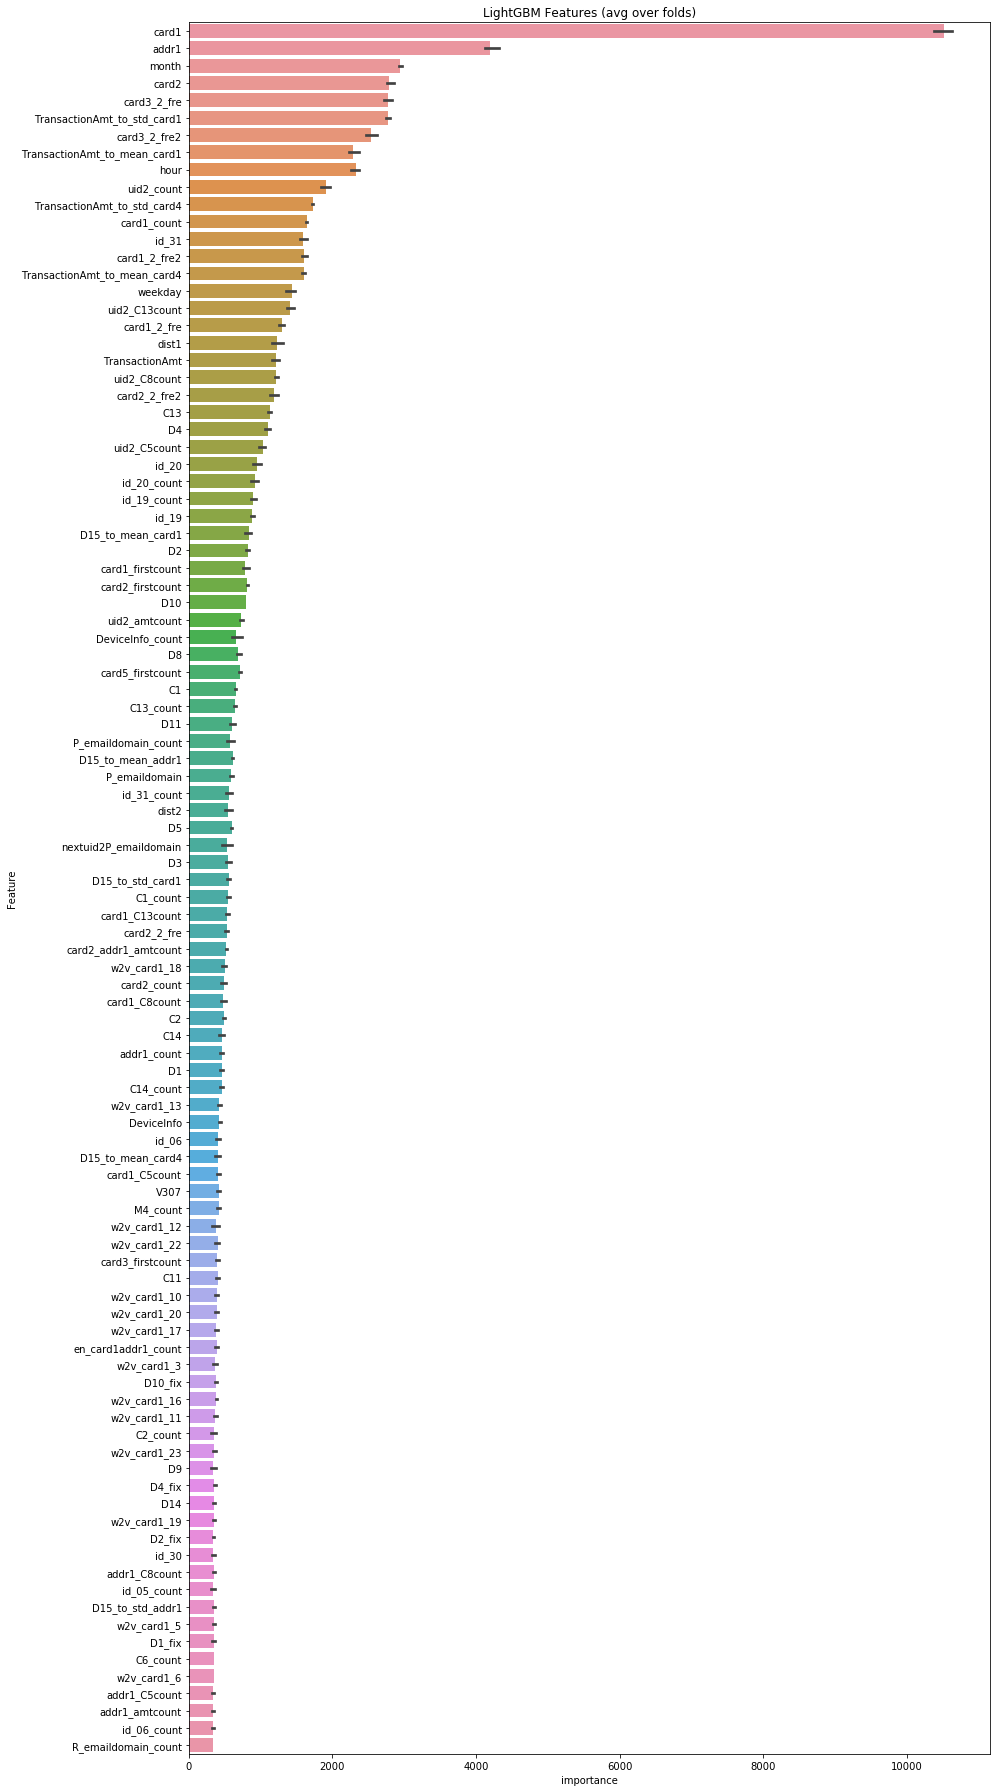

In [253]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[-100:].index)
print(cols)
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100].index)
print(cols)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [254]:
import catboost as cb
from catboost import CatBoostClassifier,Pool

# os.environ['CUDA_VISIBLE_DEVICES'] = str(2)

features = [x for x in X_train.columns if (x not in col_del ) and  not x.startswith("w2v")]
print(len(features))
cate = [x for x in features if (x == 'ProductCD' or x in ['card1','card2'] or  x.startswith("addr") or 
                                       x.endswith("domain") or x.startswith("Device")) and not x.endswith("count") and not x == "id_11" 
       and x not in train_f6.columns]

# cate = []
print(cate)
verbose_eval = 30
num_rounds = 700
y_preds3_temp = np.zeros(X_test.shape[0])
y_preds3_temp2 = np.zeros(X_test.shape[0])

folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed+1)
y_preds3 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :].fillna(-999), X_train[features].iloc[val_idx, :].fillna(-999)
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    model=cb.CatBoostClassifier(iterations=num_rounds,depth=15,learning_rate=0.04,loss_function='Logloss',eval_metric='Logloss'
                                ,min_data_in_leaf=15,l2_leaf_reg=3.0
                                ,task_type = "GPU",devices = ["1"]
                               )
    if debug:
#         model.fit(X_tr,y_tr,cat_features=cate,eval_set=(X_test[features].fillna(-999), y_test),verbose_eval = 30)
        model.fit(X_tr,y_tr,cat_features=cate,verbose_eval = 30)
    else:
#         model.fit(X_tr,y_tr,cat_features=cate,eval_set=(X_vl[features], y_vl),verbose_eval = 30)
        model.fit(X_tr,y_tr,cat_features=cate,verbose_eval = 30)
    best_iter = model.get_best_iteration()
    best_iter = 0
    print(best_iter)
    y_pred_train = model.predict_proba(X_vl,ntree_end = best_iter)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp =  model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] 
    y_preds3 += temp/ folds
    
    
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))
        best_iter = num_rounds - 100
        y_preds3_temp += model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] / folds
        best_iter = num_rounds - 200
        y_preds3_temp2 += model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] / folds
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3_temp*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3_temp*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3_temp2*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3_temp2*0.5)*0.33))

519
['ProductCD', 'card1', 'card2', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'nextuid2P_emaildomain', 'DeviceType', 'DeviceInfo']
0:	learn: 0.6175241	total: 1.36s	remaining: 15m 52s
30:	learn: 0.0885636	total: 46.4s	remaining: 16m 41s
60:	learn: 0.0632371	total: 1m 31s	remaining: 15m 53s
90:	learn: 0.0533104	total: 2m 13s	remaining: 14m 53s
120:	learn: 0.0482811	total: 2m 54s	remaining: 13m 55s
150:	learn: 0.0446844	total: 3m 35s	remaining: 13m 4s
180:	learn: 0.0420782	total: 4m 16s	remaining: 12m 14s
210:	learn: 0.0403083	total: 4m 56s	remaining: 11m 28s
240:	learn: 0.0385310	total: 5m 37s	remaining: 10m 42s
270:	learn: 0.0370464	total: 6m 17s	remaining: 9m 57s
300:	learn: 0.0356156	total: 6m 57s	remaining: 9m 13s
330:	learn: 0.0343673	total: 7m 37s	remaining: 8m 29s
360:	learn: 0.0330779	total: 8m 17s	remaining: 7m 46s
390:	learn: 0.0318073	total: 8m 57s	remaining: 7m 4s
420:	learn: 0.0307057	total: 9m 37s	remaining: 6m 22s
450:	learn: 0.0298057	total: 10m 17s	remaining: 5

In [255]:

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)/2.5),log_loss(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)/2.5))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/3.0),log_loss(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/3.0))


debug: 0.938590569503565 0.08486781853449728
debug: 0.9252874702042062 0.09804466555531258
debug: 0.926064261062245 0.09282326168717611
debug: 0.938716838500239 0.08406180025657681
debug: 0.9396666484679072 0.08367567276350484
debug: 0.9401908020823294 0.08242160063968655
debug: 0.9404645256928048 0.08382054642948923


In [256]:

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*1.5 + y_preds*1.5 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds11*1.4 + y_preds*1.6 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/5))
    

debug: 0.938590569503565 0.08486781853449728
debug: 0.9252874702042062 0.09804466555531258
debug: 0.926064261062245 0.09282326168717611
debug: 0.938716838500239 0.08406180025657681
debug: 0.9396666484679072 0.08367567276350484
debug: 0.9401908020823294 0.08670554170815808
debug: 0.9404445893344937 0.08208762487109511


In [257]:
if debug:
    X_test_pred = pd.DataFrame(index = X_test.index)
    X_test_pred['y_pred'] = y_preds
    X_test_pred['y_pred11'] = y_preds11
    X_test_pred['y_preds2'] = y_preds2
    X_test_pred['y_preds22'] = y_preds22
    X_test_pred['y_preds3'] = y_preds3
    X_test_pred['true'] = y_test
    X_test_pred.to_csv('simple_offline16.csv')
else:
    sample_submission['isFraud'] =  (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds3*0.5)/2.5
    sample_submission['isFraud'] =  (y_preds11*1.4 + y_preds*1.6 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/5
    sample_submission.to_csv('simple_ensemble16.csv')
